# CHB: 1. Image Classification Model

In [1]:
import tensorflow as tf
tfl = tf.keras.layers
tfr = tf.keras.regularizers
tfm = tf.keras.metrics
# import tensorflow.keras.layers as tfl
# import tensorflow.keras.regularizers as tfr
# import tensorflow.keras.metrics as tfm
import tensorflow_addons as tfa
import keras_tuner as kt

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 12)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# sns.set_theme(style="whitegrid")

import h5py
from PIL import Image
import imghdr


from itertools import islice

import pathlib
import os

In [2]:
# what's the version of your TensorFlow
print(tf.__version__)

# check whether you have a TF compatible GPU
tf.config.experimental.list_physical_devices('GPU')

2.9.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# fix the MEM error (which says GPU MEM is full)
gpus = tf.config.list_physical_devices('GPU')

# to set memory growth limit for each GPU (if have more than one)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Define Custom Funcs

### Funcs for Plotting

In [241]:
# define matplotlib, seaborn configs

# mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metrics:list=['loss'], auc_min:float=0.8):
  '''
  args:
      history: the output of model.fit()
      metrics: a list of metrics to be plotted
      auc_min: as we need to zoom-in more for AUC curve, we use this to limit the range
  
  returns:
      a multi plot of the performance of the model
  '''
  plt.figure(figsize=(12, 10))
  # take the ceiling of #metrics provided as the #rows
  plot_height = int(len(metrics) / 2) + 1

  for i, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(plot_height,2,i+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([auc_min,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.tight_layout();
  

def plot_metrics_finetune(history, history_finetune, initial_epoch:int, metrics:list=['loss']):
  '''
  args:
      history: the output of original model.fit()
      history_finetuen: the history of model after finetune (un-freezing layers)
      initial_epoch: the #epochs for origianl model (allow for callback if any)
      metrics: a list of metrics to be plotted
  
  returns:
      a multi plot of the performance of the model + a green line to differentiate before and after finetuning
  '''
  plt.figure(figsize=(12, 10))
  # take the ceiling of #metrics provided as the #rows
  plot_height = int(len(metrics) / 2) + 1

  for i, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(plot_height,2,i+1)
    metric_train = history.history[metric] + history_finetune.history[metric]
    metric_val = history.history['val_'+metric] + history_finetune.history['val_'+metric]
    epoch = history.epoch + history_finetune.epoch
    # plot the train metrics
    plt.plot(epoch, metric_train, color=colors[0], label='Train')
    # plot the val metrics
    plt.plot(epoch, metric_val, color=colors[1], linestyle="-", label='Val')
    # plot the vertical line (to denote fine-tune section)
    plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim([0,1]), color=colors[2], linestyle="-", label='Start Fine Tuning')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.tight_layout();

def plot_cm(labels, predictions, p=0.5, title='Confusion Matrix'):
  cm = confusion_matrix(labels, predictions > p, normalize='true')
  sns.heatmap(cm, annot=True, fmt=".1%")
  plt.title(f'{title} @{p:.2f}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

### Define metrics

In [268]:
# # simple metrics
# metrics = ['accuracy']

# metrics for binary classification
metrics = [tfm.BinaryAccuracy(name='accuracy'),
           tfm.Precision(name='precision'),
           tfm.Recall(name='recall'),
           tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1_score'),
           tfm.AUC(name='auc'),
           # tfm.AUC(name='prc', curve='PR'),  # precision-recall curve
           tfm.TruePositives(name='tp'),
           tfm.FalsePositives(name='fp'),
           tfm.TrueNegatives(name='tn'),
           tfm.FalseNegatives(name='fn')]

# define the metrics to be used in plots
# note that loss is a built-in metric
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'auc']


### Funcs for metrics

In [6]:
def history_df(history:tf.keras.callbacks.History) -> pd.DataFrame:
    '''
    args:
        history: the output of a keras models.fit() as dict (aka history.history)

    returns:
        df: a pandas DataFrame (consisting all used metrics throghout the training)
    '''
    df = pd.DataFrame(history.history)
    return df

def evaluate_model(model:tf.keras.Model, dataset:tf.data.Dataset) -> dict:
  scores = model.evaluate(dataset, verbose=0)
  metrics_names = model.metrics_names

  return dict(zip(metrics_names, scores))


def test_model_inference(model:tf.keras.Model, dataset:tf.data.Dataset, output_neurons:int):
  '''
  args:
    model: a keras model
    dataset: a TF dataset (tf.data.Dataset)
    output_neurons: an int shows the #output neurons
      e.g., 1 for binary classification, 3 for multi-class classification (with 3 labels)
  
  returns:
    a tuple of (labels, predictions)
      * in other words (y_true, y_pred)
  '''
  inferences = model.predict(dataset, verbose=0)

  if output_neurons == 1:
    # for binary classification
    y_true = [elem[1].numpy() for elem in dataset.unbatch()]
    y_pred = inferences
  elif output_neurons > 1:
    # for multi-class classification
    y_true = [tf.argmax(elem[1]).numpy() for elem in dataset.unbatch()]
    y_pred = tf.argmax(inferences, axis=1).numpy()
  else:
    raise Exception('output_neurons arg must be an int >= 1')

  return y_true, y_pred

### Define transfer learning model creator

In [7]:
def tl_model_builder(pretrained_model, input_shape, preprocess_layer=None, drop_prob=0, lambda_=0, value_range=(0.0, 1.0)):
    '''
    
    args:
        preprocess_layer: if the pretrained_model has a built-in (ready-to-use) preprocessing layer to force the inputs of the model to go throught the same preprocessing steps as the its inputs when training on a huge dataset (e.g., ImageNet)
    '''
    # freeze the classification phase layers (use them only for feature extraction)
    pretrained_model.trainable = False

    # build a model (on top of the base/pretrained model)
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # data img augmentation model
    # must be after preprocess layer, as the tfl.RandomBrightness needs to know the value_range of inputs
    x = img_augmentation_model(input_shape, value_range=value_range)(x)

    if preprocess_layer:
        # the pretrain model's own preprocess
        x = preprocess_layer(x)
    else:
        # preprocess the data (resize, normalize, etc.)
        # tekboart preprocess model
        x = preprocess_img_model(input_shape, value_range=value_range)(x)

    # give a name to the pretrained model 
    pretrained_model._name = 'pretrained_model'
    # the base/pretrained model
    x = pretrained_model(x, training=False)

    # to collapse the output of base/pretrained model
    # does the Flattening as well
    x = tfl.GlobalAveragePooling2D(name='global_avg_pool')(x)  

    # to add regularization
    x = tfl.Dropout(drop_prob)(x)  

    # add more FC layers for a stronger classification
    # x = tfl.Dense(4480, kernel_regularizer=tfr.l2(lambda_))(x)
    # x = tfl.BatchNormalization()(x)
    # x = tfl.ELU()(x)
    # x = tfl.Dropout(drop_prob)(x)

    # x = tfl.Dense(2240, kernel_regularizer=tfr.l2(lambda_))(x)
    # x = tfl.BatchNormalization()(x)
    # x = tfl.ELU()(x)
    # x = tfl.Dropout(drop_prob)(x)

    x = tfl.Dense(100, kernel_regularizer=tfr.l2(lambda_), name='FC1')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.ELU()(x)
    # x = tfl.Dropout(drop_prob)(x)

    # output layer
    # x = tfl.Dense(num_classes, activation='softmax')(x)  # for multi-class classification
    x = tfl.Dense(1, activation='sigmoid', name='output_layer')(x)  # for binary classification
    outputs = x

    model = tf.keras.Model(inputs, outputs)
    return model

## Create Dataset (from images)
> for binary classification

> class 0: Need Restoration, class 1: No Need Restoration

### define the dir (containing the pics)

In [8]:
# method 1 (caveman): use only os.path (don't use as the following cells need pathlib.Path)
# data_dir = os.path.join(image_dir, 'data', '')

# method 2 (sophi): use pathlib (has many facilites)
# data_dir = pathlib.Path(os.path.join('data', ''))
# data_dir = pathlib.Path('/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/1. Image Classification')
data_dir = pathlib.Path(os.path.join('..', '..', '..', '..', '..','Thesis Data', 'Pix', '0 Model Ready Data', '1. Image Classification', ''))
print('data_dir:', data_dir)

data_dir: ../../../../../Thesis Data/Pix/0 Model Ready Data/1. Image Classification


### Count the total #images 

In [9]:
# this cell only works if all the images are in the root of classes dir/folder
# so if you have nested dirs it will not work (since maxdepth=1)
jpg_image_count = len(list(data_dir.glob('*/*.jpg')))
JPG_image_count = len(list(data_dir.glob('*/*.JPG')))
jpeg_image_count = len(list(data_dir.glob('*/*.jpeg')))
png_image_count = len(list(data_dir.glob('*/*.png')))
PNG_image_count = len(list(data_dir.glob('*/*.PNG')))

print('jpg image_count:', jpg_image_count)
print('JPG image_count:', JPG_image_count)
print('jpeg image_count:', jpeg_image_count)
print('png image_count:', png_image_count)

print(f'total images in data dir:', (jpg_image_count + JPG_image_count + jpeg_image_count + png_image_count))
print(f'total files in data dir:', len(list(data_dir.glob('*/*'))))

jpg image_count: 0
JPG image_count: 0
jpeg image_count: 0
png image_count: 0
total images in data dir: 0
total files in data dir: 4


### find/clean the files that are not suitable for dataset
> Check for files that are not image , or that are not what their extension says they are to avoid futere bugs/erros

In [10]:
import imghdr

supported_types = ["bmp", "gif", "jpeg", "png"]  # the image types supported by TF

# # method 1 (stackoverflow)
# img_extensions = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions (existent in data_dir)
# not_img = []  # to be filled with files that are not img
# not_supported_by_tf = []  # to be filled with unsupported img files (by TF)

# for filepath in pathlib.Path(data_dir).rglob("*"):  # get all the files in the 'data_dir'
#     if filepath.suffix.lower() in img_extensions:  # check if the file has one the provided img_extensions
#         img_type = imghdr.what(filepath)  # get the file's type
#         if img_type is None:  # if the file was not an img
#             not_img.append(filepath)
#             print(f"{filepath} is not an image")
#         elif img_type not in supported_types:  # if the file is an img but not supported by TF
#             not_supported_by_tf.append(filepath)
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
# print('-'*79)

# method 2 (tekboart): doesn't need us to define file extensions in data_dir (namely var img_extensions)
# so this method check all files (not just the provided extentions)
not_img = []  # to be filled with files that are not img
not_supported_by_tf = []  # to be filled with unsupported img files (by TF)

for filepath in pathlib.Path(data_dir).rglob("*"):  # get all the files in the 'data_dir'
    if filepath.suffix.lower().startswith('.'):  # check if filepath is a file (not a dir)
        img_type = imghdr.what(filepath)  # get the file's type
        if img_type is None:  # if the file was not an img
            not_img.append(filepath)
            print(f"{filepath} is not an image")
        elif img_type not in supported_types:  # if the file is an img but not supported by TF
            not_supported_by_tf.append(filepath)
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

print('-'*79)

# remove these files from dirs (permanently)
filepaths_to_rm = [*not_img, *not_supported_by_tf]
print('#files to be removed:', len(filepaths_to_rm))

for filepath in filepaths_to_rm:
    print("removed", filepath)
    # os.remove(filepath)  # uncomment only if you are sure about the removal

-------------------------------------------------------------------------------
#files to be removed: 0


### Create the train/dev datasets (using keras utils)

In [11]:
# define the batch_size
# this is important to ensure that each batch has a decent chance of containing a few inferior label samples (i.e., NO restoration label). 
# If the batch size was too small, they would likely have no inferior label samples to learn from.
batch_size = 32

# define the image size (after resizing)
# input_shape = (64, 64, 3)
# input_shape = (160, 160, 3)  # for MobileNet_v2 pretrained on ImageNet
input_shape = (224, 224, 3)  # for MobileNet_v2 pretrained on ImageNet
# input_shape = (512, 512, 3)

# seed = np.random.randint(low=1, high=123)
seed = 123

print('\033[92m creating train set \033[0m'.center(79, '-'))
# must use the same seed for train, val, test sets, otherwise they might overlap (as the process becomes random)
train_ds_temp = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    label_mode='int',
    class_names=['NO restoration', 'YES restoration'],
    validation_split=0.3,
    subset="training",
    seed=seed,
    image_size=(input_shape[0], input_shape[1]),
    crop_to_aspect_ratio=False,
    shuffle=True,  # default True
    batch_size=batch_size)  # default 32

print('\033[91m creating val set \033[0m'.center(79, '-'))
val_ds_temp = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    label_mode='int',
    class_names=['NO restoration', 'YES restoration'],
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(input_shape[0], input_shape[1]),
    crop_to_aspect_ratio=False,
    shuffle=True,
    batch_size=batch_size)


------------------------- creating train set -------------------------
Found 10537 files belonging to 2 classes.
Using 7376 files for training.
-------------------------- creating val set --------------------------
Found 10537 files belonging to 2 classes.
Using 3161 files for validation.


### define the final train, val and test sets
> actually in this step we divide the val set into two sets namely, val and test.

In [12]:
train_ds_orig = train_ds_temp

# determine how many batches of data are available in the validation set 
val_batches = tf.data.experimental.cardinality(val_ds_temp).numpy()
print('#mini_batches in val_ds_temp:', val_batches)


# set how much of val set to be used for test set
# e.g., moving 20% of them to a test set.
# (remember: 34 * 20 / 100 == 34 / 5)
p_test = 0.5

# define final test set
# test_ds_orig = val_ds_temp.take(val_batches // 5)
test_ds_orig = val_ds_temp.take(int(val_batches * p_test))
print('#mini_batches in test_ds_orig:', test_ds_orig.cardinality().numpy())

# define final val set
# val_ds_orig = val_ds_temp.skip(val_batches // 5)
val_ds_orig = val_ds_temp.skip(int(val_batches * p_test))
print('#mini_batches in val_ds_orig:', val_ds_orig.cardinality().numpy())

#mini_batches in val_ds_temp: 99
#mini_batches in test_ds_orig: 49
#mini_batches in val_ds_orig: 50


### Calc the #recs/images per label/calss for each dataset and collectively.

In [13]:
# method 1 (slow)
# num_classes = len({label.numpy() for elem in train_ds_orig for label in elem[1]})
# method 2 (fast): works only with datasets created with keras.utils
num_classes = len(train_ds_orig.class_names)
print(dict(zip(train_ds_orig.class_names, range(num_classes))), end="\n\n")

# Give weights to diff classes
# calc the #recs (in all mini_batches) for each label (i.e., NO/YES) for each set
train_negative = sum(np.sum(elem[1].numpy() == 0) for elem in train_ds_orig)
train_positive = sum(np.sum(elem[1].numpy() == 1) for elem in train_ds_orig)

val_negative = sum(np.sum(elem[1].numpy() == 0) for elem in val_ds_orig)
val_positive = sum(np.sum(elem[1].numpy() == 1) for elem in val_ds_orig)

test_negative = sum(np.sum(elem[1].numpy() == 0) for elem in test_ds_orig)
test_positive = sum(np.sum(elem[1].numpy() == 1) for elem in test_ds_orig)

neg = train_negative + val_negative + test_negative
pos = train_positive + val_positive + test_positive
total = neg + pos

# print train set
print(f'Examples:\n    train set: {train_negative + train_positive}\n'
      f'    label 0 (Negative): {train_negative} ({(train_negative / (train_negative + train_positive))*100:.2f}% of total)\n'
      f'    label 1 (Positive): {train_positive} ({(train_positive / (train_negative + train_positive))*100:.2f}% of total)\n')

# print val set
print(f'Examples:\n    val set: {val_negative + val_positive}\n'
      f'    label 0 (Negative): {val_negative} ({(val_negative / (val_negative + val_positive))*100:.2f}% of total)\n'
      f'    label 1 (Positive): {val_positive} ({(val_positive / (val_negative + val_positive))*100:.2f}% of total)\n')

# print test set
print(f'Examples:\n    test set: {test_negative + test_positive}\n'
      f'    label 0 (Negative): {test_negative} ({(test_negative / (test_negative + test_positive))*100:.2f}% of total)\n'
      f'    label 1 (Positive): {test_positive} ({(test_positive / (test_negative + test_positive))*100:.2f}% of total)\n')

# print total
print(f'Examples:\n    Total: {total}\n'
      f'    label 0 (Negative): {neg} ({(neg / total)*100:.2f}% of total)\n'
      f'    label 1 (Positive): {pos} ({(pos / total)*100:.2f}% of total)\n')

{'NO restoration': 0, 'YES restoration': 1}

Examples:
    train set: 7376
    label 0 (Negative): 1018 (13.80% of total)
    label 1 (Positive): 6358 (86.20% of total)

Examples:
    val set: 1593
    label 0 (Negative): 207 (12.99% of total)
    label 1 (Positive): 1386 (87.01% of total)

Examples:
    test set: 1559
    label 0 (Negative): 207 (13.28% of total)
    label 1 (Positive): 1352 (86.72% of total)

Examples:
    Total: 10528
    label 0 (Negative): 1432 (13.60% of total)
    label 1 (Positive): 9096 (86.40% of total)



### visualize the label/class distributin in diff data sets

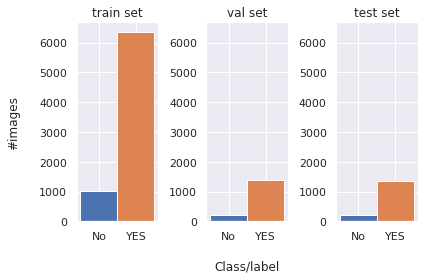

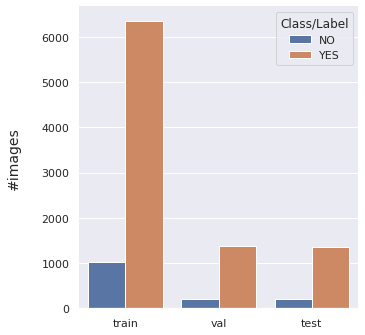

In [14]:

x = [train_negative, train_positive, val_negative, val_positive, test_negative, test_positive]
max_recs = max(x)

# using matplot
plt.subplot(1, 3, 1)
plt.bar('No', train_negative, width=1)
plt.bar('YES', train_positive, width=1)
plt.title('train set')
plt.ylabel('#images\n', fontsize=12)
plt.ylim(0, max_recs+max_recs*0.05)

plt.subplot(1, 3, 2)
plt.bar('No', val_negative, width=1)
plt.bar('YES', val_positive, width=1)
plt.title('val set')
plt.xlabel('\nClass/label', fontsize=12)
plt.ylim(0, max_recs+max_recs*0.05)

plt.subplot(1, 3, 3)
plt.bar('No', test_negative, width=1)
plt.bar('YES', test_positive, width=1)
plt.title('test set')
plt.ylim(0, max_recs+max_recs*0.05)

plt.tight_layout()
plt.show()

# using pandas + seaborn
df = pd.DataFrame({'set': ['train', 'train', 'val', 'val', 'test', 'test'], 'label': ['NO', 'YES']*3, 'recs': x})
# display(df)

g = sns.catplot(
    data=df,
    x="set",
    y="recs",
    hue="label",
    kind="bar",
    height=5,
    ci="sd", 
    # palette='husl', # set the color palette
    # alpha=0.6,  # set the opacity
)

sns.set(style="darkgrid")
g.despine(left=True)
g.set_axis_labels("", "#images\n", fontsize=14)
# g.legend.set_title("class/label", )
g._legend.remove()  # to remove sns automatic legend (and use matplot's)
plt.legend(loc='upper right', title='Class/Label')
plt.show()

### calc the weight of each calss

In [200]:
# Scaling by total/num_classes helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

# # method 1: calc weight based on all sets (think it's wrong as we only update weights with train set)
# weight_for_0 = (1 / neg) * (total / num_classes)
# weight_for_1 = (1 / pos) * (total / num_classes)

# method 2: calc weight based on just the train set
total = train_negative + train_positive
# formula 1
# weight_for_0 = (1 / train_negative) * (total / num_classes)
# weight_for_1 = (1 / train_positive) * (total / num_classes)

# formula 2
# weight_for_0 = total / (num_classes * train_negative)
# weight_for_1 = total / (num_classes * train_positive)
# weight_for_0 = weight_for_0/(weight_for_0 + weight_for_1)
# weight_for_1 = weight_for_1/(weight_for_0 + weight_for_1)
# weight_for_1 = 1 - weight_for_0

# formula 3
# weight_for_0 = total / (num_classes * train_negative)
# weight_for_1 = total / (num_classes * train_positive)
# weight_for_0 = weight_for_0/(weight_for_0 + weight_for_1)
# weight_for_1 = weight_for_1/(weight_for_0 + weight_for_1)

# formula 4
# weight_for_0 = total / (num_classes * train_negative)
# weight_for_1 = total / (num_classes * train_positive)
# weight_for_0 = weight_for_0/(weight_for_0 + weight_for_1)
# weight_for_1 = 1 - weight_for_0

# methodt 3: set the weight by manual finetuning (according to dev error)
weight_for_0 = 2
weight_for_1 = 1

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.00
Weight for class 1: 1.00


### Check the final train set's elements shapes

In [16]:
# shows None (in shapes) if the #elsms in the last mini_batch < batch_size
print('each elem\'s images shape:', train_ds_orig.element_spec[0].shape)
print('each elem\'s labels shape:', train_ds_orig.element_spec[1].shape)

print('.'*79)

# method 2 (sophi): doesn't show None in shapes
images_batch, labels_batch = next(iter(train_ds_orig))
print('each elem\'s images shape:', images_batch.shape)
print('each elem\'s labels shape:', labels_batch.shape)

# # could use a for-loop too (TF documentation) (but caveman)
# for images_batch, labels_batch in train_ds:
#     print('each elem\'s images shape:', images_batch.shape)
#     print('each elem\'s labels shape:', labels_batch.shape)
#     break

print('-'*79)

# print the labels/classes
class_names = train_ds_orig.class_names
print("the classes/labels:", class_names)

each elem's images shape: (None, 224, 224, 3)
each elem's labels shape: (None,)
...............................................................................
each elem's images shape: (32, 224, 224, 3)
each elem's labels shape: (32,)
-------------------------------------------------------------------------------
the classes/labels: ['NO restoration', 'YES restoration']


### Visualize the created img datasets

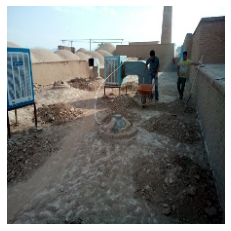

In [17]:
# take a single image from a mini_batch (in train_ds)
# i.e., the 1st img from the first batch
an_img = next(iter(train_ds_orig))[0][0]

plt.imshow(an_img.numpy().astype('uint8'))
plt.axis('off')
plt.show()

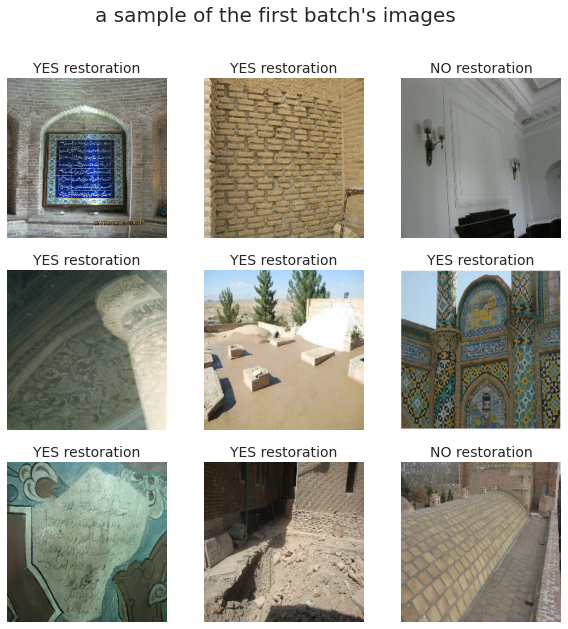

In [18]:
# Show some sample images
class_names = train_ds_orig.class_names

# method 2 (tekboart): no for-loop
plt.figure(figsize=(10, 10))

images, labels = next(iter(train_ds_orig))  # take a mini_batch (i.e., a tuple) and unpack it (images_batch, labels_batch)
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]], fontsize=14)
  plt.axis("off")
plt.suptitle('a sample of the first batch\'s images', fontsize=20)
plt.show()

## Pre-Process data

### Normalization

In [19]:
# normalize images to [0, 1]
# train_ds_norm = train_ds_orig.map(lambda x, y: (tf.cast(x, tf.float32)/255., y))
# val_ds_norm = val_ds_orig.map(lambda x, y: (tf.cast(x, tf.float32)/255., y))
# test_ds_norm = test_ds_orig.map(lambda x, y: (tf.cast(x, tf.float32)/255., y))

# normalize images to [-1, 1]
# train_ds_norm = train_ds_orig.map(lambda x, y: ((tf.cast(x, tf.float32)/127.5)-1, y))
# val_ds_norm = val_ds_orig.map(lambda x, y: ((tf.cast(x, tf.float32)/127.5)-1, y))
# test_ds_norm = test_ds_orig.map(lambda x, y: ((tf.cast(x, tf.float32)/127.5)-1, y))

# Check the min & max of pixel values for an image
# max_ = np.max(next(iter(train_ds_norm))[0].numpy())
# min_ = np.min(next(iter(train_ds_norm))[0].numpy())
# print(f'max: {max_}, min: {min_}')

### One-hot encoding
> No need, since we are doing binary classification

In [20]:
# train_ds_hot = train_ds_norm.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
# val_ds_hot = val_ds_norm.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
# test_ds_hot = test_ds_norm.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

# print('train set labels shape:', train_ds_hot.element_spec[1].shape)
# print('val set labels shape:', val_ds_hot.element_spec[1].shape)

### Configure the dataset for performance
> now after this step your datasets are ready to be used in a Keras model 

In [21]:
# Use buffered prefetching to load images from disk without having I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_orig.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_orig.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_orig.cache().prefetch(buffer_size=AUTOTUNE)

## data augmentation

### data augmentation (in pure TF)
> in pure TF so not suitable with working with Keras models, as the batch_size 'None' will not work with it

> to use it we either use it in dataset.map() func or in a data pipeline

> in contrast to Keras data augmentation methods we need to somehow turn of the data_augmentation_tf during evaluate or predict time

2022-09-05 08:16:42.241255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


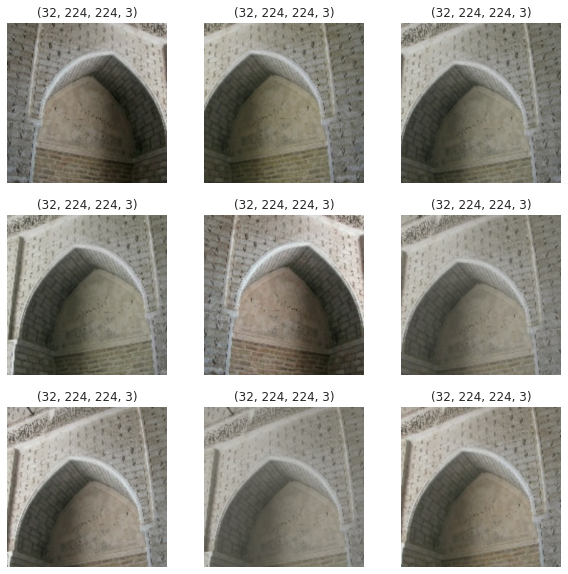

In [22]:
# method 1: using a func (inside can use both TF_funcs & keras_layers)
def data_augmentation_tf(img):
  '''
  tekboart's custome img augmentation pipline

  args:
    img: An image as a rank-4 tensor (NHWC)
    input_shape: a tuple (H, W, C)
    batch_size: the number of images in each batch

  returns:
    x: an augmented image tensor (with the same shape as input img)
  '''
  x = img

  # step 1: augment the color, brightness, contrast, saturation
  x = tf.image.random_brightness(x, max_delta=.05)
  x = tf.image.random_contrast(x, lower=.6, upper=1.2)
  x = tf.image.random_saturation(x, 0.75, 1.1)
  x = tf.image.random_hue(x, 0.03)
  
  # step 2: flip, crop, resize, center, change quality of the img
  x = tf.image.random_flip_left_right(x)
  # x = tfl.RandomRotation(0.02)(x)

  input_shape = img.shape
  crop_ratio = 0.9  # means keep 90% of the img (or crop 10% of img)
  if len(input_shape) == 3:
    H = input_shape[0]
    W = input_shape[1]
    C = input_shape[2]
    crop_H = int(H * crop_ratio)
    crop_W = int(W * crop_ratio)
    # do random crop
    x = tf.image.random_crop(x, size=(crop_H, crop_W, C))
    # resize and center the cropped image (as we changed the img size & center by random crop)
    num_cropped_pixels_H = H - crop_H
    num_cropped_pixels_W = W - crop_W
    # use 2* because i.e., in height we cropped some pixels (e.g., 16) from both top & bottom (hence a total of 2*16=32 pixels were cropped)
    x = tf.image.resize(x, ((H+2*num_cropped_pixels_H), (W+2*num_cropped_pixels_W)))
    x = x[num_cropped_pixels_H:-num_cropped_pixels_H, num_cropped_pixels_W:-num_cropped_pixels_W, :]
    # Randomly change jpeg encoding quality for inducing jpeg noise.
    x = tf.image.random_jpeg_quality(x, 80, 100)
  elif len(input_shape) == 4:
    N = input_shape[0]
    H = input_shape[1]
    W = input_shape[2]
    C = input_shape[3]
    crop_H = int(H * crop_ratio)
    crop_W = int(W * crop_ratio)
    x = tf.image.random_crop(x, size=(N, crop_H, crop_W, C))
    # resize and center the cropped image (as we changed the img size & center by random crop)
    num_cropped_pixels_H = H - crop_H
    num_cropped_pixels_W = W - crop_W
    # use 2* because i.e., in height we cropped some pixels (e.g., 16) from both top & bottom (hence a total of 2*16=32 pixels were cropped)
    x = tf.image.resize(x, ((H+2*num_cropped_pixels_H), (W+2*num_cropped_pixels_W)))
    x = x[:, num_cropped_pixels_H:-num_cropped_pixels_H, num_cropped_pixels_W:-num_cropped_pixels_W, :]

    # Randomly change jpeg encoding quality for inducing jpeg noise.
    x_new = tf.zeros([1, H, W, C], dtype=tf.float32)
    for i in range(N):
      img_ch_quality = tf.image.random_jpeg_quality(x[i], 80, 100)
      x_new = tf.concat([x_new, tf.expand_dims(img_ch_quality, 0)], axis=0)
    x = x_new[1:]

  return x

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = np.array(Image.open(grace_hopper).resize((input_shape[0], input_shape[1]))).astype(np.float32)/255.
image = np.expand_dims(grace_hopper, axis=0)
# plt.imshow(image[0])

# if images are [0..1] (normalized)
# images = next(iter(train_ds))[0]
# if images are [0..255]
images = next(iter(train_ds))[0]/255.

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_images = data_augmentation_tf(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0])
  plt.title(augmented_images.shape)
  plt.axis("off")

### data augmentation (in Keras)

2022-09-05 08:16:44.234284: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


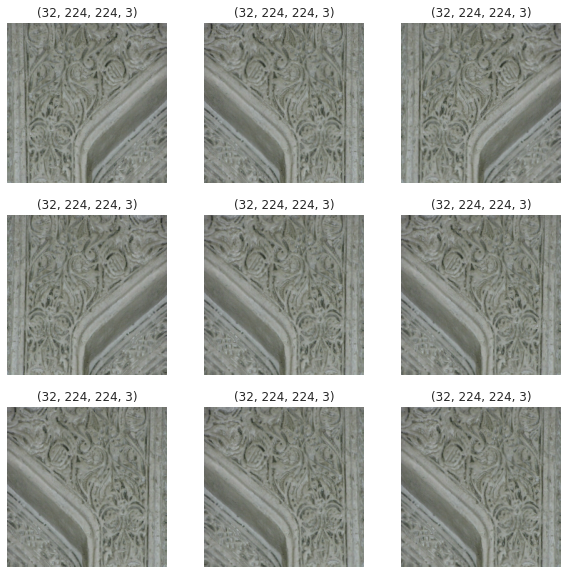

In [23]:
# method 2: using Keras Seq model
def img_augmentation_model(input_shape:tuple=None, value_range:tuple=(0.0, 255.0)) -> tf.keras.Sequential.__class__:
    '''
    augment img data to reduce overfitting and make the model more robust
    * pros of this model: using Keras for Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).

    arguments:
        input_shape: the shape of the input images (to this func)
        value_range: tuple of 2 floats for the lower and upper limit of the values of the input data. 
          * Defaults to [0.0, 255.0]. Can be changed to e.g. [0.0, 1.0] or [-1.0, 1.0] if the image input has been scaled before this layer.
          * The brightness adjustment will be scaled to this range, and the output values will be clipped to this range.

    returns:
        tf.keras.Sequential
    '''
    model = tf.keras.Sequential()
    # model.add(tfl.RandomBrightness(factor=.1, value_range=value_range))
    # model.add(tfl.RandomContrast(.6, 1.2))  # extreamly slow
    model.add(tfl.RandomFlip("horizontal"))
    # model.add(tfl.RandomTranslation(.1, .1))
    # model.add(tfl.RandomZoom(0.9))
    model.add(tfl.RandomRotation(0.005))

    # model.add(tfl.RandomCrop(int(input_shape[0]*.95), int(input_shape[1]*.95)))
    # CenterCrop is not so good as RandomCrop, it's deterministic for the same H, W (so less randomness)
    # model.add(tf.keras.layers.CenterCrop(int(input_shape[0]*.9), int(input_shape[1]*.9)))

    # resize back the augmented image to the input's shape
    # no need if use a preprocessing layer after it (to resize the inputs)
    # model.add(tfl.Resizing(input_shape[0], input_shape[1]))
    return model

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = np.array(Image.open(grace_hopper).resize((input_shape[0], input_shape[1]))).astype(np.float32)/255.
images = np.expand_dims(grace_hopper, axis=0)
# plt.imshow(image[0])

# if images are [0..1] (normalized)
# images = next(iter(train_ds))[0]
# if images are [0..255]
images = next(iter(train_ds))[0]/255.

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_images = img_augmentation_model(input_shape, value_range=(0.0, 1.0))(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0])
  plt.title(augmented_images.shape)
  plt.axis("off")

In [24]:
def preprocess_img_model(input_shape:tuple=None, value_range:tuple=None) -> tf.keras.Sequential.__class__:
    '''
    preprocess the inputs (in train, evaluate and predict), so no need for data piplines (specially in prediction)

    arguments:
        input_shape: the shape of the input images (to this func)
        value_range: a tuple of floates define the final range, after normalization (should be either (-1.0, 1.0), (0.0, 1.0)
            * Note: If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1, 1] or [0, 1], 
            * if not sure can instead of this func use the included preprocess_input function (if any):
            e.g., preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    returns:
        tf.keras.Sequential
    '''
    model = tf.keras.Sequential()

    if input_shape:
        # we do resizing before normalization, 
        # as why normalizing a 1000x1000 input when we can do it for a 64x64 input?
        model.add(tfl.Resizing(input_shape[0], input_shape[1]))
    
    if value_range:
        if tuple(value_range) == (-1.0, 1.0):
            model.add(tfl.Rescaling(1./127.5, offset=-1))
        elif tuple(value_range) == (0.0, 1.0):
            model.add(tfl.Rescaling(1./255., offset=0))
    
    return model

## Create Model

### ResNet50

#### 1. Create a ResNet50 from scratch (with Functional API)

##### Create an IdentityBlock (with Functional API)
> Identity Block is a ResBlock in which the result of "main path" and the input (of main math) have the same shape

In [269]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, drop_prob=0, lambda_=0):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = tfl.Conv2D(filters= F2, kernel_size=f, padding='same', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = tfl.Conv2D(filters= F3, kernel_size=1, kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)

    return X

##### Create an Convolutional Block (with Functional API)
> Convolutional Block is a ResBlock in which the result of "main path" and the input (of main math) have the same shape

> I think this Convolution Block is the same as a Bottleneck Block (in MobileNet v2)

In [270]:

# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, drop_prob=0, lambda_=0):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    
    ## Second component of main path (≈3 lines)
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)

    ## Third component of main path (≈2 lines)
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    
    return X

##### Create the Final ResNet50

In [283]:

# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape, drop_prob=0, l2_lambda=0):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = tf.keras.Input(input_shape)
    X = X_input

    # Zero-Padding
    X = tfl.ZeroPadding2D((3, 3))(X)
    
    # Stage 1
    X = tfl.Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [64, 64, 256], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [64, 64, 256], drop_prob=drop_prob, lambda_=l2_lambda)
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [512, 512, 2048], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [512, 512, 2048], drop_prob=drop_prob, lambda_=l2_lambda)

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # X = tfl.AveragePooling2D(pool_size=(2, 2))(X)
    # X = tfl.Flatten()(X)

    # # # output layer
    # # X = tfl.Dense(classes, activation='softmax')(X)  # for multi-class classification
    # X = tfl.Dense(1, activation='sigmoid')(X)  # for binary classification
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X)

    return model

##### Modifty the Final ResNet50 (from scratch)
> by adding preprocessing, data augmentation, output layer, regularization, etc.

In [284]:
def tekboart_ResNet50(input_shape, drop_prob=0, l2_lambda=0, value_range=(0.0, 1.0)):
    '''
    instantiate a keras model with preprocessing, img augmentation, etc.
    '''
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # data img augmentation model
    # must be after preprocess layer, as the tfl.RandomBrightness needs to know the value_range of inputs
    x = img_augmentation_model(input_shape, value_range=value_range)(x)

    # preprocess the data (resize, normalize, etc.)
    x = preprocess_img_model(input_shape, value_range=value_range)(x)

    # ResNet model (without output layer)
    x = ResNet50(input_shape, drop_prob=0.0, l2_lambda=0.0)(x)

    # to collaps the output of the ResNetModel
    x = tfl.GlobalAveragePooling2D()(x)
    
    # add dropout regularization
    x = tfl.Dropout(drop_prob)(x)

    # flatten the layer into (m, n_x) format
    # BeCo the GlobalAveragePooling is not needed
    # x = tfl.Flatten()(x)

    x = tfl.Dense(100, kernel_regularizer=tfr.l2(l2_lambda), name='FC1')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.ELU()(x)
    # x = tfl.Dropout(drop_prob)(x)

    # output layer
    x = tfl.Dense(1, activation='sigmoid')(x)  # for binary classification
    outputs = x

    model = tf.keras.Model(inputs, outputs)
    return model

##### instantiate a ResNet50 model

In [285]:
ResNet50_scratch = tekboart_ResNet50(input_shape=input_shape,
                                     drop_prob=0.8,
                                     l2_lambda=0.1,
                                     value_range=(-1.0, 1.0))

print(ResNet50_scratch.summary())
# tf.keras.utils.plot_model(ResNet50_scratch)

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_65 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_66 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 model_56 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1339 (Dropout)      (None, 2048)              0         
                                                          

##### Train the ResNet50

In [286]:
# compile the model
# set LR_decay method
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.96,
    staircase=True)

ResNet50_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         metrics=metrics)

In [287]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',
    # monitor='val_f1_score',
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [288]:
epochs = 100

ResNet50_scratch_history = ResNet50_scratch.fit(
    train_ds.take(10),
    validation_data=val_ds.take(10),
    initial_epoch=0,
    epochs=epochs,
    # callbacks=[early_stopping],  # dont use early_stopping as we lose orthoginalization
    # class_weight=None)
    class_weight=class_weight)

Epoch 1/100
10/10 [==============================] - 14s 659ms/step - loss: 9.3669 - accuracy: 0.8000 - precision: 0.8668 - recall: 0.9076 - f1_score: 0.8867 - auc: 0.5417 - tp: 501.0000 - fp: 77.0000 - tn: 11.0000 - fn: 51.0000 - val_loss: 6.0885 - val_accuracy: 0.2875 - val_precision: 0.8400 - val_recall: 0.2258 - val_f1_score: 0.3559 - val_auc: 0.5041 - val_tp: 63.0000 - val_fp: 12.0000 - val_tn: 29.0000 - val_fn: 216.0000
Epoch 2/100
10/10 [==============================] - 5s 481ms/step - loss: 4.3382 - accuracy: 0.8344 - precision: 0.8548 - recall: 0.9707 - f1_score: 0.9091 - auc: 0.4351 - tp: 265.0000 - fp: 45.0000 - tn: 2.0000 - fn: 8.0000 - val_loss: 3.0342 - val_accuracy: 0.8719 - val_precision: 0.8719 - val_recall: 1.0000 - val_f1_score: 0.9316 - val_auc: 0.4468 - val_tp: 279.0000 - val_fp: 41.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 5s 480ms/step - loss: 3.2635 - accuracy: 0.8313 - precision: 0.8567 - recall: 0.9634

In [289]:
df_metrics = history_df(ResNet50_scratch_history)

# method 1: ugly print
display(df_metrics)

# method 2: clean print
# merge the metrics for both train & val (e.g., merge loss and val_loss)
for feat in df_metrics.columns:
    df_metrics.rename(columns={feat: feat.replace('val_', '')}, inplace=True)

train_set_margin = int(len(df_metrics.columns)/2)
sets_metrics_separate = {'train': df_metrics.iloc[-1][:train_set_margin],
                         'val': df_metrics.iloc[-1][train_set_margin:]}

print('last epoch\'s metrics (of diff sets)')
display(pd.DataFrame(sets_metrics_separate))

loss  accuracy  precision    recall      f1_score       auc     tp  \
0   9.366887  0.800000   0.866782  0.907609  [0.88672566]  0.541728  501.0   
1   4.338206  0.834375   0.854839  0.970696  [0.90909094]  0.435079  265.0   
2   3.263494  0.831250   0.856678  0.963370   [0.9068966]  0.524277  263.0   
3   2.564045  0.831250   0.856678  0.963370   [0.9068966]  0.519874  263.0   
4   2.216306  0.840625   0.853503  0.981685   [0.9131175]  0.447315  268.0   
..       ...       ...        ...       ...           ...       ...    ...   
95  0.611836  0.881250   0.877814  1.000000  [0.93493146]  0.605370  273.0   
96  0.606422  0.878125   0.877419  0.996337   [0.9331046]  0.648118  272.0   
97  0.611220  0.878125   0.877419  0.996337   [0.9331046]  0.590913  272.0   
98  0.610434  0.878125   0.877419  0.996337   [0.9331046]  0.579963  272.0   
99  0.601129  0.875000   0.877023  0.992674  [0.93127143]  0.636427  271.0   

      fp    tn    fn  val_loss  val_accuracy  val_precision  val_recall  \
0   77.0  11.0  51.0  6.088500      0.287500       0.840000    0.225806   
1   45.0   2.0   8.0  3.034181      0.871875       0.871875    1.000000   
2   44.0   3.0  10.0  2.754521      0.828125       0.880952    0.928315   
3   44.0   3.0  10.0  1.894850      0.837500       0.877076    0.946237   
4   46.0   1.0   5.0  1.875562      0.871875       0.871875    1.000000   
..   ...   ...   ...       ...           ...            ...         ...   
95  38.0   9.0   0.0  0.480616      0.834375       0.876667    0.942652   
96  38.0   9.0   1.0  0.479086      0.831250       0.876254    0.939068   
97  38.0   9.0   1.0  0.475254      0.834375       0.876667    0.942652   
98  38.0   9.0   1.0  0.476891      0.834375       0.876667    0.942652   
99  38.0   9.0   2.0  0.474742      0.834375       0.876667    0.942652   

    val_f1_score   val_auc  val_tp  val_fp  val_tn  val_fn  
0    [0.3559322]  0.504065    63.0    12.0    29.0   216.0  
1    [0.9315525]  0.446848   279.0    41.0     0.0     0.0  
2   [0.90401393]  0.541831   259.0    35.0     6.0    20.0  
3    [0.9103448]  0.561850   264.0    37.0     4.0    15.0  
4    [0.9315525]  0.543186   279.0    41.0     0.0     0.0  
..           ...       ...     ...     ...     ...     ...  
95   [0.9084629]  0.545633   263.0    37.0     4.0    16.0  
96  [0.90657437]  0.534356   262.0    37.0     4.0    17.0  
97   [0.9084629]  0.547513   263.0    37.0     4.0    16.0  
98   [0.9084629]  0.547119   263.0    37.0     4.0    16.0  
99   [0.9084629]  0.526051   263.0    37.0     4.0    16.0  

[100 rows x 20 columns]

last epoch's metrics (of diff sets)


train          val
loss           0.601129     0.474742
accuracy          0.875     0.834375
precision      0.877023     0.876667
recall         0.992674     0.942652
f1_score   [0.93127143]  [0.9084629]
auc            0.636427     0.526051
tp                271.0        263.0
fp                 38.0         37.0
tn                  9.0          4.0
fn                  2.0         16.0

##### Plot the training performance

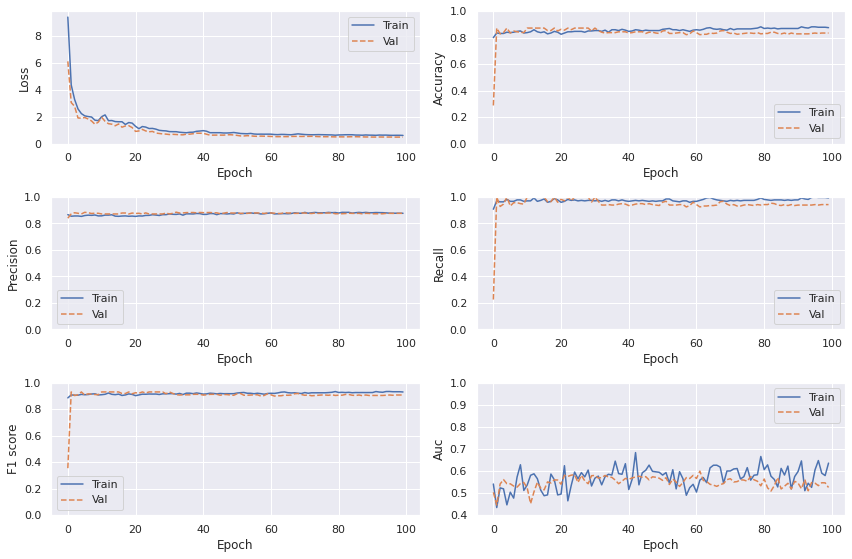

In [290]:
# if using class_weight then loss of train set is not comparable (with that of val set)
# metrics_names = ResNet50_scratch.metrics_names
plot_metrics(ResNet50_scratch_history, metrics=metrics_names, auc_min=0.4)
plt.tight_layout()
plt.show()

##### Evaluate the Model (MobileNet)

In [291]:
model = ResNet50_scratch

a = pd.Series(evaluate_model(model, train_ds), name='Train')
b = pd.Series(evaluate_model(model, val_ds), name='Val')
c = pd.Series(evaluate_model(model, test_ds), name='Test')

df = pd.concat([a, b, c], axis=1)
print('Model evaluation on diff sets')
display(df)

Model evaluation on diff sets


Train           Val         Test
loss           0.476993      0.469968      0.47176
accuracy       0.831752       0.83553     0.834821
precision      0.867442      0.873916     0.870183
recall         0.949984      0.947216     0.950517
f1_score   [0.90683883]  [0.90909094]  [0.9085775]
auc            0.540094      0.544365     0.540163
tp               6040.0        1310.0       1287.0
fp                923.0         189.0        192.0
tn                 95.0          21.0         22.0
fn                318.0          73.0         67.0

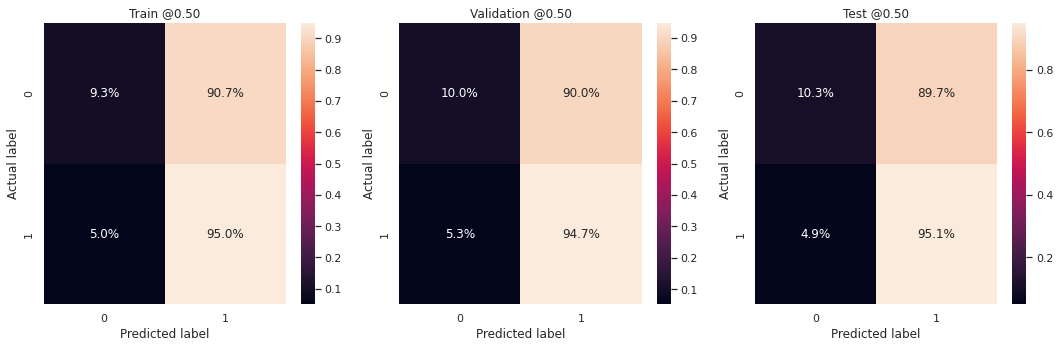

In [292]:
model = ResNet50_scratch
datasets = [train_ds, val_ds, test_ds]
datasets_names = iter(['Train', 'Validation', 'Test'])  # should not touch the test set before 1-2 weeks before thesis

# plot the confustion matrices resulted from predicting datasets
plt.figure(figsize=(15,5))
for i in range(len(datasets)):
  dataset_name = next(datasets_names)
  y_true, y_pred = test_model_inference(model, datasets[i], output_neurons=1)
  plt.subplot(1, len(datasets), i+1)
  plot_cm(y_true, y_pred, title=dataset_name)
  # plt.plot([1, 2, 3], [4, 5, 6])

plt.tight_layout()
plt.show()

##### predict with the ResNet50 (from scratch)

In [ ]:
model = ResNet50_scratch

# define the resize_shape
shape = model.input_shape
resize_shape = (shape[1], shape[2])

# define image address
# addr = r'/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/75.JPG'
# addr = r"F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"
addr = r"F:\Thesis Data\Pix\0 Model Ready Data\1. Image Classification\NO restoration\ME\IMG_4579.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = model.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")

if inference.squeeze() < .5:
    confidence = (1. - inference.squeeze()).round(2)
    print('confidence:\n', confidence)
else:
    confidence =  inference.squeeze().round(2)
    print('confidence:\n', confidence)

# for binary classification 
label = (inference.squeeze()).round()  # used .squeeze() since the shape of inference is (1, C)
# for multi-class classification 
# label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)

plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}, conf={confidence}')
plt.show

#### 2. Load a pretrained ResNet50
> we just use a pretrained ResNet50 (trained with ImageNet) to do transfer learning

In [222]:
# ResNet50_pretrained = tf.keras.models.load_model('/run/media/tekboart/SP 2TB/CE - CS/Development/Exercise/00 Resources/Models/resnet50.h5')
# ResNet50v2_pretrained = tf.keras.applications.ResNet50V2(input_shape=input_shape, include_top=False, weights='imagenet')
ResNet152v2_pretrained = tf.keras.applications.ResNet152V2(input_shape=input_shape, include_top=False, weights='imagenet')

ResNet_pretrained = ResNet152v2_pretrained

# load the preprocessing of the base/pretrained model
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [223]:
# instantiate a Transfer Learning Model
ResNet_tl = tl_model_builder(ResNet_pretrained,
                             input_shape=input_shape,
                             preprocess_layer=preprocess_input,
                             drop_prob=0.7,
                             lambda_=0.01,
                             value_range=(-1.0, 1.0))

In [224]:
# compile the model

# set LR_decay method
base_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

ResNet_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metrics)

In [225]:
# check the performance of pretrained model (before training the added layers)
loss0, accuracy0, *_ = ResNet_tl.evaluate(val_ds, verbose=0)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.83
initial accuracy: 0.51


##### Train the added layers 
> to the pretrained ResNet50v2

In [226]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # monitor='val_prc',
    # monitor='val_auc',
    verbose=0,
    # patience=5,
    patience=10,
    mode='auto',
    restore_best_weights=True)

In [227]:
initial_epochs = 10

ResNet_tl_history = ResNet_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    initial_epoch=0,
    # callbacks=[early_stopping],  # dont use early_stopping as we lose orthoginalization
    # class_weight=None)
    class_weight=class_weight)

Epoch 1/10
231/231 [==============================] - 78s 290ms/step - loss: 1.4104 - accuracy: 0.7341 - precision: 0.9195 - recall: 0.7579 - f1_score: 0.8309 - auc: 0.7346 - tp: 4819.0000 - fp: 422.0000 - tn: 596.0000 - fn: 1539.0000 - val_loss: 0.7756 - val_accuracy: 0.8487 - val_precision: 0.9319 - val_recall: 0.8908 - val_f1_score: 0.9109 - val_auc: 0.8429 - val_tp: 1232.0000 - val_fp: 90.0000 - val_tn: 120.0000 - val_fn: 151.0000
Epoch 2/10
231/231 [==============================] - 67s 289ms/step - loss: 0.8401 - accuracy: 0.8177 - precision: 0.9155 - recall: 0.8687 - f1_score: 0.8915 - auc: 0.7801 - tp: 5523.0000 - fp: 510.0000 - tn: 508.0000 - fn: 835.0000 - val_loss: 0.5627 - val_accuracy: 0.8713 - val_precision: 0.9268 - val_recall: 0.9248 - val_f1_score: 0.9258 - val_auc: 0.8589 - val_tp: 1279.0000 - val_fp: 101.0000 - val_tn: 109.0000 - val_fn: 104.0000
Epoch 3/10
231/231 [==============================] - 67s 289ms/step - loss: 0.6811 - accuracy: 0.8346 - precision: 0.9145

##### Plot the training performance

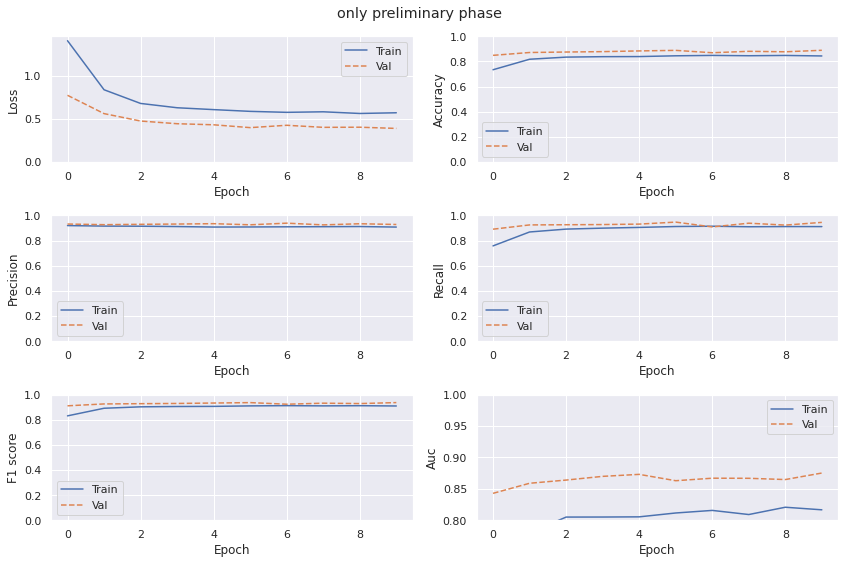

In [228]:
# if using class_weight then loss of train set is not comparable (with that of val set)
# metrics_names = MobileNet_tl.metrics_names
plot_metrics(ResNet_tl_history, metrics=metrics_names)
plt.suptitle('only preliminary phase')
plt.tight_layout()
plt.show()

In [215]:
df_metrics = history_df(ResNet_tl_history)

# method 1: ugly print
display(df_metrics)

# method 2: clean print
# merge the metrics for both train & val (e.g., merge loss and val_loss)
for feat in df_metrics.columns:
    df_metrics.rename(columns={feat: feat.replace('val_', '')}, inplace=True)

train_set_margin = int(len(df_metrics.columns)/2)
sets_metrics_separate = {'train': df_metrics.iloc[-1][:train_set_margin],
                         'val': df_metrics.iloc[-1][train_set_margin:]}

print('last epoch\'s metrics (of diff sets)')
display(pd.DataFrame(sets_metrics_separate))

loss  accuracy  precision    recall      f1_score       auc      tp  \
0   1.400856  0.754881   0.917584  0.786254  [0.84685755]  0.748902  4999.0   
1   0.825256  0.825244   0.915696  0.878106  [0.89650744]  0.797250  5583.0   
2   0.664596  0.843547   0.916720  0.900283  [0.90842724]  0.819331  5724.0   
3   0.612822  0.846529   0.917146  0.903586  [0.91031533]  0.824804  5745.0   
4   0.578596  0.847072   0.918534  0.902642   [0.9105188]  0.835481  5739.0   
..       ...       ...        ...       ...           ...       ...     ...   
25  0.520342  0.857918   0.917190  0.918056  [0.91762304]  0.843325  5837.0   
26  0.513648  0.859273   0.919162  0.917427   [0.9182934]  0.848824  5833.0   
27  0.514370  0.855206   0.918645  0.912866  [0.91574633]  0.846842  5804.0   
28  0.503938  0.856291   0.918351  0.914596  [0.91646963]  0.850498  5815.0   
29  0.506175  0.860629   0.920878  0.917112   [0.9189913]  0.851772  5831.0   

       fp     tn      fn  val_loss  val_accuracy  val_precision  val_recall  \
0   449.0  569.0  1359.0  0.796142      0.827370       0.938986    0.856833   
1   514.0  504.0   775.0  0.524459      0.888261       0.930050    0.942155   
2   520.0  498.0   634.0  0.437150      0.889517       0.923509    0.951555   
3   519.0  499.0   613.0  0.441567      0.878217       0.935531    0.923355   
4   509.0  509.0   619.0  0.395989      0.888261       0.926398    0.946493   
..    ...    ...     ...       ...           ...            ...         ...   
25  527.0  491.0   521.0  0.389534      0.867545       0.940602    0.904555   
26  513.0  505.0   525.0  0.349995      0.893283       0.926812    0.952278   
27  514.0  504.0   554.0  0.350388      0.888261       0.935018    0.936370   
28  517.0  501.0   543.0  0.348591      0.892655       0.934720    0.942155   
29  501.0  517.0   527.0  0.358650      0.884495       0.936635    0.929863   

    val_f1_score   val_auc  val_tp  val_fp  val_tn  val_fn  
0   [0.89603025]  0.858604  1185.0    77.0   133.0   198.0  
1    [0.9360632]  0.865811  1303.0    98.0   112.0    80.0  
2    [0.9373219]  0.874076  1316.0   109.0   101.0    67.0  
3    [0.9294032]  0.868622  1277.0    88.0   122.0   106.0  
4    [0.9363376]  0.873584  1309.0   104.0   106.0    74.0  
..           ...       ...     ...     ...     ...     ...  
25   [0.9222263]  0.874419  1251.0    79.0   131.0   132.0  
26   [0.9393723]  0.879782  1317.0   104.0   106.0    66.0  
27   [0.9356937]  0.882144  1295.0    90.0   120.0    88.0  
28   [0.9384228]  0.883135  1303.0    91.0   119.0    80.0  
29  [0.93323654]  0.879835  1286.0    87.0   123.0    97.0  

[30 rows x 20 columns]

last epoch's metrics (of diff sets)


train           val
loss          0.506175       0.35865
accuracy      0.860629      0.884495
precision     0.920878      0.936635
recall        0.917112      0.929863
f1_score   [0.9189913]  [0.93323654]
auc           0.851772      0.879835
tp              5831.0        1286.0
fp               501.0          87.0
tn               517.0         123.0
fn               527.0          97.0

In [231]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(ResNet_pretrained.layers))

Number of layers in the base model:  564


##### Fine-tune the top layers (of the base/pretrained model)

In [232]:
#  unfreeze the base_model
ResNet_pretrained.trainable = True

# set the bottom layers to be un-trainable.
# Fine-tune from this layer onwards
# fine_tune_at = 140  # for ResNet50v2
fine_tune_at = 500  # for ResNet152v2

# Freeze all the layers before the `fine_tune_at` layer
for layer in ResNet_pretrained.layers[:fine_tune_at]:
    layer.trainable = False

# recompile the model (necessary for these changes to take effect)
# As you are training a much larger model and want to readapt the pretrained weights,
# it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

# set LR_decay method (for fine-tuning)
fine_tune_lr = 1e-8
# fine_tune_lr = base_learning_rate/100
lr_schedule_finetune = tf.keras.optimizers.schedules.ExponentialDecay(
    fine_tune_lr,
    decay_steps=300,
    decay_rate=0.96,
    staircase=True)

ResNet_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_finetune),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=metrics)

In [61]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',
    # monitor='val_prc',
    monitor='val_auc',
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [233]:
# resume training
fine_tune_epochs = 10
# might differ from initial_epochs if used early stopping
initial_epochs_real = len(ResNet_tl_history.history['loss'])
total_epochs =  initial_epochs_real + fine_tune_epochs

ResNet_tl_finetune_history = ResNet_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs_real,
    # callbacks=[early_stopping],  # dont use early_stopping as we lose orthoginalization
    # class_weight=None)
    class_weight=class_weight)

Epoch 11/20
231/231 [==============================] - 93s 363ms/step - loss: 0.5487 - accuracy: 0.8653 - precision: 0.9120 - recall: 0.9339 - f1_score: 0.9228 - auc: 0.8428 - tp: 7202.0000 - fp: 695.0000 - tn: 537.0000 - fn: 510.0000 - val_loss: 0.3819 - val_accuracy: 0.8889 - val_precision: 0.9246 - val_recall: 0.9494 - val_f1_score: 0.9369 - val_auc: 0.8754 - val_tp: 1313.0000 - val_fp: 107.0000 - val_tn: 103.0000 - val_fn: 70.0000
Epoch 12/20
231/231 [==============================] - 82s 356ms/step - loss: 0.5559 - accuracy: 0.8598 - precision: 0.9069 - recall: 0.9332 - f1_score: 0.9198 - auc: 0.8281 - tp: 5933.0000 - fp: 609.0000 - tn: 409.0000 - fn: 425.0000 - val_loss: 0.3798 - val_accuracy: 0.8927 - val_precision: 0.9250 - val_recall: 0.9537 - val_f1_score: 0.9391 - val_auc: 0.8755 - val_tp: 1319.0000 - val_fp: 107.0000 - val_tn: 103.0000 - val_fn: 64.0000
Epoch 13/20
231/231 [==============================] - 82s 355ms/step - loss: 0.5547 - accuracy: 0.8612 - precision: 0.908

##### Plot the training performance

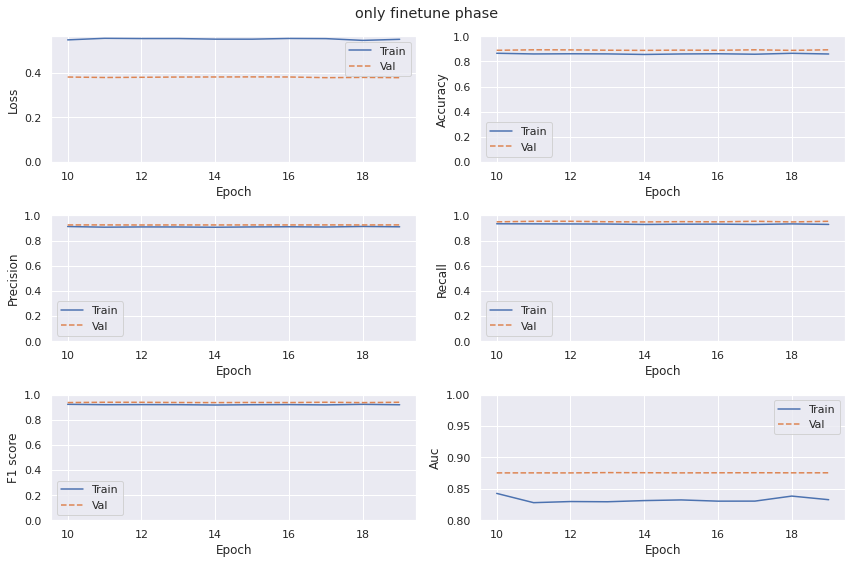

In [237]:
# metrics_names = ResNet_tl.metrics_names
plot_metrics(ResNet_tl_finetune_history, metrics=metrics_names)
plt.suptitle('only finetune phase')
plt.tight_layout()
plt.show()

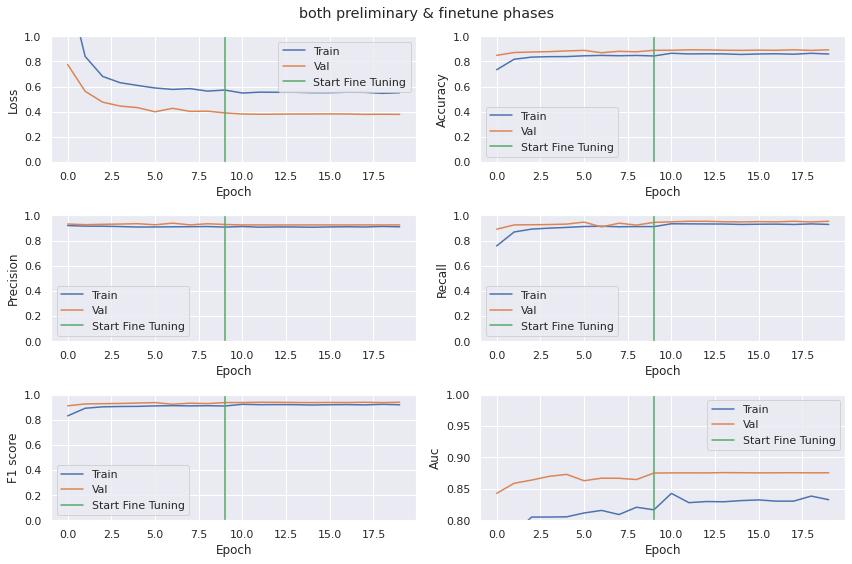

In [242]:
# metrics_names = MobileNetv3_tl.metrics_names
plot_metrics_finetune(ResNet_tl_history,
                      ResNet_tl_finetune_history,
                      initial_epochs_real,
                      metrics=metrics_names)
plt.suptitle('both preliminary & finetune phases')
plt.tight_layout()
plt.show()

In [243]:
df_metrics = history_df(ResNet_tl_finetune_history)
display(df_metrics)
# df_metrics.iloc[-1]

loss  accuracy  precision    recall      f1_score       auc      tp  \
0  0.548729  0.865273   0.911992  0.933869  [0.92280096]  0.842813  7202.0   
1  0.555868  0.859816   0.906909  0.933155    [0.919845]  0.828067  5933.0   
2  0.554731  0.861171   0.908798  0.932526   [0.9205092]  0.829845  5929.0   
3  0.554835  0.860222   0.908450  0.931740   [0.9199472]  0.829508  5924.0   
4  0.551988  0.855748   0.906356  0.928594     [0.91734]  0.831364  5904.0   
5  0.551908  0.859680   0.908895  0.930481   [0.9195616]  0.832426  5916.0   
6  0.555214  0.861307   0.910195  0.930953  [0.92045724]  0.830465  5919.0   
7  0.554393  0.857646   0.908308  0.928594   [0.9183388]  0.830528  5904.0   
8  0.546454  0.864967   0.912462  0.932841  [0.92253846]  0.838533  5931.0   
9  0.551256  0.859409   0.909875  0.928908   [0.9192933]  0.832783  5906.0   

      fp     tn     fn  val_loss  val_accuracy  val_precision  val_recall  \
0  695.0  537.0  510.0  0.381851      0.888889       0.924648    0.949385   
1  609.0  409.0  425.0  0.379752      0.892655       0.924965    0.953724   
2  595.0  423.0  429.0  0.380647      0.892028       0.924317    0.953724   
3  597.0  421.0  434.0  0.381786      0.889517       0.924701    0.950108   
4  610.0  408.0  454.0  0.382047      0.888261       0.924595    0.948662   
5  593.0  425.0  442.0  0.382432      0.890144       0.924754    0.950832   
6  584.0  434.0  439.0  0.382011      0.888889       0.924648    0.949385   
7  596.0  422.0  454.0  0.379017      0.892655       0.924965    0.953724   
8  569.0  449.0  427.0  0.380102      0.888261       0.924595    0.948662   
9  585.0  433.0  452.0  0.378945      0.892655       0.924965    0.953724   

  val_f1_score   val_auc  val_tp  val_fp  val_tn  val_fn  
0  [0.9368534]  0.875431  1313.0   107.0   103.0    70.0  
1  [0.9391242]  0.875483  1319.0   107.0   103.0    64.0  
2    [0.93879]  0.875421  1319.0   108.0   102.0    64.0  
3  [0.9372325]  0.875898  1314.0   107.0   103.0    69.0  
4  [0.9364739]  0.875710  1312.0   107.0   103.0    71.0  
5  [0.9376114]  0.875481  1315.0   107.0   103.0    68.0  
6  [0.9368534]  0.875600  1313.0   107.0   103.0    70.0  
7  [0.9391242]  0.875702  1319.0   107.0   103.0    64.0  
8  [0.9364739]  0.875538  1312.0   107.0   103.0    71.0  
9  [0.9391242]  0.875598  1319.0   107.0   103.0    64.0

##### Evaluate the Model (ResNet50v2_tl)

In [244]:
model = ResNet_tl

a = pd.Series(evaluate_model(model, train_ds), name='Train')
b = pd.Series(evaluate_model(model, val_ds), name='Val')
c = pd.Series(evaluate_model(model, test_ds), name='Test')

df = pd.concat([a, b, c], axis=1)
print('Model evaluation on diff sets')
display(df)

Model evaluation on diff sets


Train          Val         Test
loss          0.375744     0.378945     0.375423
accuracy      0.884355     0.892655     0.890306
precision     0.916604     0.924965     0.919149
recall        0.952501     0.953724     0.957164
f1_score   [0.9342075]  [0.9391242]  [0.9377713]
auc           0.890728     0.875598     0.881832
tp              6056.0       1319.0       1296.0
fp               551.0        107.0        114.0
tn               467.0        103.0        100.0
fn               302.0         64.0         58.0

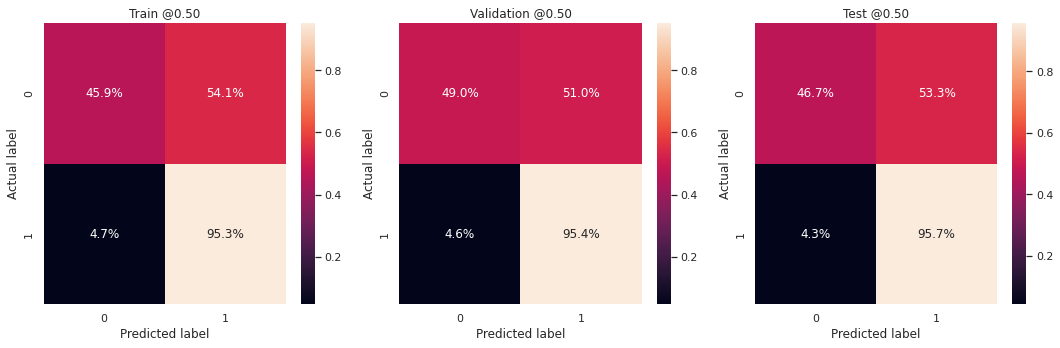

In [245]:
model = ResNet_tl
datasets = [train_ds, val_ds, test_ds]
datasets_names = iter(['Train', 'Validation', 'Test'])  # should not touch the test set before 1-2 weeks before thesis

# plot the confustion matrices resulted from predicting datasets
plt.figure(figsize=(15,5))
for i in range(len(datasets)):
  dataset_name = next(datasets_names)
  y_true, y_pred = test_model_inference(model, datasets[i], output_neurons=1)
  plt.subplot(1, len(datasets), i+1)
  plot_cm(y_true, y_pred, title=dataset_name)
  # plt.plot([1, 2, 3], [4, 5, 6])

plt.tight_layout()
plt.show()

##### predict with the ResNet50v2_tl

img_final shape: (1, 160, 160, 3)
the inference:
[[0.36]]
confidence:
 0.64


<function matplotlib.pyplot.show(close=None, block=None)>

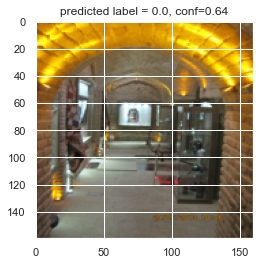

In [ ]:
model = ResNet_tl

# define the resize_shape
shape = model.input_shape
resize_shape = (shape[1], shape[2])

# define image address
# addr = r'/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/75.JPG'
# addr = r"F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"
addr = r"F:\Thesis Data\Pix\0 Model Ready Data\1. Image Classification\NO restoration\ME\IMG_4579.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = model.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")

if inference.squeeze() < .5:
    confidence = (1. - inference.squeeze()).round(2)
    print('confidence:\n', confidence)
else:
    confidence =  inference.squeeze().round(2)
    print('confidence:\n', confidence)

# for binary classification 
label = (inference.squeeze()).round()  # used .squeeze() since the shape of inference is (1, C)
# for multi-class classification 
# label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)

plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}, conf={confidence}')
plt.show

### MobileNet

#### 3. Load a pretrained MobileNet
> we just use a pretrained MobileNet (trained with ImageNet) to do transfer learning

In [34]:
# MobileNetv3_pretrained = tf.keras.applications.MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
MobileNetV2_pretrained = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

MobileNet_pretrained = MobileNetV2_pretrained
# give a name to the pretrained model 
MobileNet_pretrained

# load the preprocessing of the base/pretrained model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [63]:
# instantiate a Transfer Learning Model
MobileNet_tl = tl_model_builder(MobileNet_pretrained,
                                input_shape=input_shape,
                                preprocess_layer=preprocess_input,
                                drop_prob=0.5,
                                lambda_=0.01,
                                value_range=(-1.0, 1.0))

##### Find the best Hyper parameters
<a href="https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/">improve-class-imbalance-class-weights</a><br>
<a href="https://www.tensorflow.org/tutorials/keras/keras_tuner">keras_tuner</a>

In [64]:
# def hp_finetune_model():
#     MobileNet_tl

# # Instantiate the tune
# tuner = kt.RandomSearch(hp_finetune_model,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=3,
#                      directory='my_dir',
#                      project_name='intro_to_kt')


# #Setting the range for class weights
# weights = np.linspace(0.0,0.99,200)

# #Creating a dictionary grid for grid search
# param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

##### Train the Model With the best hyper parameters

In [65]:
# compile the model
# set LR_decay method
base_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

MobileNet_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metrics)

In [66]:
# check the performance of pretrained model (before training the added layers)
loss0, accuracy0, *_ = MobileNet_tl.evaluate(val_ds, verbose=0)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.69
initial accuracy: 0.68


##### Train the added layers 
> to the pretrained Model

In [67]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # monitor='val_prc',
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [68]:
initial_epochs = 30

MobileNet_tl_history = MobileNet_tl.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=0,
    epochs=initial_epochs,
    # callbacks=[early_stopping],  # dont use early_stopping as we lose orthoginalization
    # class_weight=None)
    class_weight=class_weight)

Epoch 1/30
231/231 [==============================] - 25s 89ms/step - loss: 1.5300 - accuracy: 0.7627 - precision: 0.9211 - recall: 0.7927 - f1-score: 0.8521 - auc: 0.7636 - tp: 5040.0000 - fp: 432.0000 - tn: 586.0000 - fn: 1318.0000 - val_loss: 0.8132 - val_accuracy: 0.8770 - val_precision: 0.9282 - val_recall: 0.9308 - val_f1-score: 0.9295 - val_auc: 0.8682 - val_tp: 1292.0000 - val_fp: 100.0000 - val_tn: 105.0000 - val_fn: 96.0000
Epoch 2/30
231/231 [==============================] - 20s 86ms/step - loss: 0.8351 - accuracy: 0.8327 - precision: 0.9235 - recall: 0.8787 - f1-score: 0.9005 - auc: 0.8262 - tp: 5587.0000 - fp: 463.0000 - tn: 555.0000 - fn: 771.0000 - val_loss: 0.5064 - val_accuracy: 0.8889 - val_precision: 0.9127 - val_recall: 0.9647 - val_f1-score: 0.9380 - val_auc: 0.8762 - val_tp: 1339.0000 - val_fp: 128.0000 - val_tn: 77.0000 - val_fn: 49.0000
Epoch 3/30
231/231 [==============================] - 20s 85ms/step - loss: 0.6534 - accuracy: 0.8406 - precision: 0.9235 - re

##### Plot the training performance

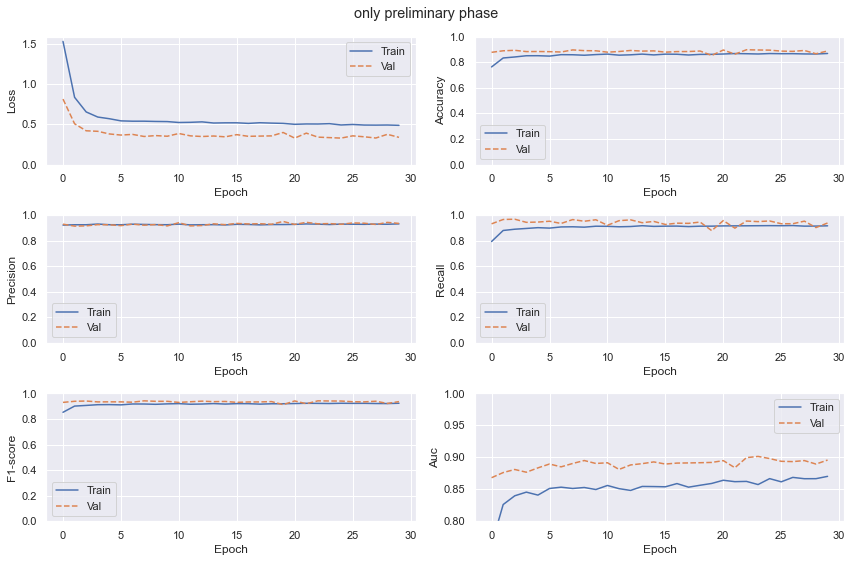

In [70]:
# if using class_weight then loss of train set is not comparable (with that of val set)
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'f1-score', 'auc',]
# metrics_names = MobileNet_tl.metrics_names
plot_metrics(MobileNet_tl_history, metrics=metrics_names)
plt.suptitle('only preliminary phase')
plt.tight_layout()
plt.show()

In [71]:
df_metrics = history_df(MobileNet_tl_history)

# method 1: ugly print
display(df_metrics)

# method 2: clean print
# merge the metrics for both train & val (e.g., merge loss and val_loss)
for feat in df_metrics.columns:
    df_metrics.rename(columns={feat: feat.replace('val_', '')}, inplace=True)

train_set_margin = int(len(df_metrics.columns)/2)
sets_metrics_separate = {'train': df_metrics.iloc[-1][:train_set_margin],
                         'val': df_metrics.iloc[-1][train_set_margin:]}

print('last epoch\'s metrics (of diff sets)')
display(pd.DataFrame(sets_metrics_separate))


loss  accuracy  precision    recall      f1-score       auc      tp  \
0   1.529969  0.762744   0.921053  0.792702  [0.85207105]  0.763589  5040.0   
1   0.835100  0.832701   0.923471  0.878735  [0.90054804]  0.826188  5587.0   
2   0.653372  0.840564   0.923504  0.888644    [0.905739]  0.839872  5650.0   
3   0.589926  0.850190   0.928956  0.894621   [0.9114654]  0.845601  5688.0   
4   0.569122  0.850461   0.923859  0.900755   [0.9121606]  0.840969  5727.0   
..       ...       ...        ...       ...           ...       ...     ...   
25  0.497646  0.866052   0.927684  0.916011   [0.9218107]  0.861728  5824.0   
26  0.490508  0.866323   0.926891  0.917270  [0.92205536]  0.868642  5832.0   
27  0.489575  0.864290   0.928629  0.912708  [0.92059964]  0.866573  5803.0   
28  0.490982  0.863612   0.927476  0.913180  [0.92027265]  0.866641  5806.0   
29  0.486865  0.867815   0.930296  0.915225   [0.9226988]  0.870252  5819.0   

       fp     tn      fn  val_loss  val_accuracy  val_precision  val_recall  \
0   432.0  586.0  1318.0  0.813205      0.876962       0.928161    0.930836   
1   463.0  555.0   771.0  0.506428      0.888889       0.912747    0.964697   
2   468.0  550.0   708.0  0.419224      0.892655       0.914792    0.966859   
3   435.0  583.0   670.0  0.412597      0.882611       0.924382    0.942363   
4   472.0  546.0   631.0  0.379901      0.883239       0.923239    0.944524   
..    ...    ...     ...       ...           ...            ...         ...   
25  454.0  564.0   534.0  0.356159      0.886378       0.937636    0.931556   
26  460.0  558.0   526.0  0.344496      0.884495       0.935601    0.931556   
27  446.0  572.0   555.0  0.329227      0.891400       0.925718    0.951729   
28  454.0  564.0   552.0  0.375222      0.865662       0.942018    0.901297   
29  436.0  582.0   539.0  0.337460      0.887633       0.933955    0.937320   

    val_f1-score   val_auc  val_tp  val_fp  val_tn  val_fn  
0    [0.9294964]  0.868166  1292.0   100.0   105.0    96.0  
1    [0.9380035]  0.876170  1339.0   128.0    77.0    49.0  
2    [0.9401051]  0.881008  1342.0   125.0    80.0    46.0  
3    [0.9332857]  0.876711  1308.0   107.0    98.0    80.0  
4   [0.93376064]  0.883514  1311.0   109.0    96.0    77.0  
..           ...       ...     ...     ...     ...     ...  
25   [0.9345862]  0.893785  1293.0    86.0   119.0    95.0  
26   [0.9335741]  0.893322  1293.0    89.0   116.0    95.0  
27  [0.93854356]  0.894915  1321.0   106.0    99.0    67.0  
28   [0.9212077]  0.889469  1251.0    77.0   128.0   137.0  
29   [0.9356346]  0.895747  1301.0    92.0   113.0    87.0  

[30 rows x 20 columns]

last epoch's metrics (of diff sets)


train          val
loss          0.486865      0.33746
accuracy      0.867815     0.887633
precision     0.930296     0.933955
recall        0.915225      0.93732
f1-score   [0.9226988]  [0.9356346]
auc           0.870252     0.895747
tp              5819.0       1301.0
fp               436.0         92.0
tn               582.0        113.0
fn               539.0         87.0

##### Fine-tune the top layers (of the base/pretrained model)

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(MobileNet_pretrained.layers))

Number of layers in the base model:  154


In [73]:
#  unfreeze the base_model
MobileNet_pretrained.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# set the bottom layers to be un-trainable.
# Freeze all the layers before the `fine_tune_at` layer
for layer in MobileNet_pretrained.layers[:fine_tune_at]:
    layer.trainable = False

# recompile the model (necessary for these changes to take effect)
# As you are training a much larger model and want to readapt the pretrained weights,
# it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

# set LR_decay method (for fine-tuning)
fine_tune_lr = 1e-6
# fine_tune_lr = base_learning_rate/100
lr_schedule_finetune = tf.keras.optimizers.schedules.ExponentialDecay(
    fine_tune_lr,
    decay_steps=300,
    decay_rate=0.96,
    staircase=True)

MobileNet_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_finetune),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     metrics=metrics)

In [74]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # monitor='val_prc',
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [75]:
# resume training
fine_tune_epochs = 10
# might differ from initial_epochs if used early stopping
initial_epochs_real = len(MobileNet_tl_history.history['loss'])
total_epochs =  initial_epochs_real + fine_tune_epochs

MobileNet_tl_finetune_history = MobileNet_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs_real,
    # callbacks=[early_stopping],  # dont use early_stopping as we lose orthoginalization
    # class_weight=None)
    class_weight=class_weight)

Epoch 31/40
231/231 [==============================] - 32s 119ms/step - loss: 0.4778 - accuracy: 0.8760 - precision: 0.9260 - recall: 0.9305 - f1-score: 0.9283 - auc: 0.8773 - tp: 7175.0000 - fp: 573.0000 - tn: 660.0000 - fn: 536.0000 - val_loss: 0.3239 - val_accuracy: 0.8914 - val_precision: 0.9233 - val_recall: 0.9546 - val_f1-score: 0.9387 - val_auc: 0.8967 - val_tp: 1325.0000 - val_fp: 110.0000 - val_tn: 95.0000 - val_fn: 63.0000
Epoch 32/40
231/231 [==============================] - 26s 111ms/step - loss: 0.4785 - accuracy: 0.8739 - precision: 0.9254 - recall: 0.9286 - f1-score: 0.9270 - auc: 0.8746 - tp: 5904.0000 - fp: 476.0000 - tn: 542.0000 - fn: 454.0000 - val_loss: 0.3241 - val_accuracy: 0.8914 - val_precision: 0.9239 - val_recall: 0.9539 - val_f1-score: 0.9387 - val_auc: 0.8974 - val_tp: 1324.0000 - val_fp: 109.0000 - val_tn: 96.0000 - val_fn: 64.0000
Epoch 33/40
231/231 [==============================] - 25s 110ms/step - loss: 0.4673 - accuracy: 0.8795 - precision: 0.9323 

##### Plot the training performance

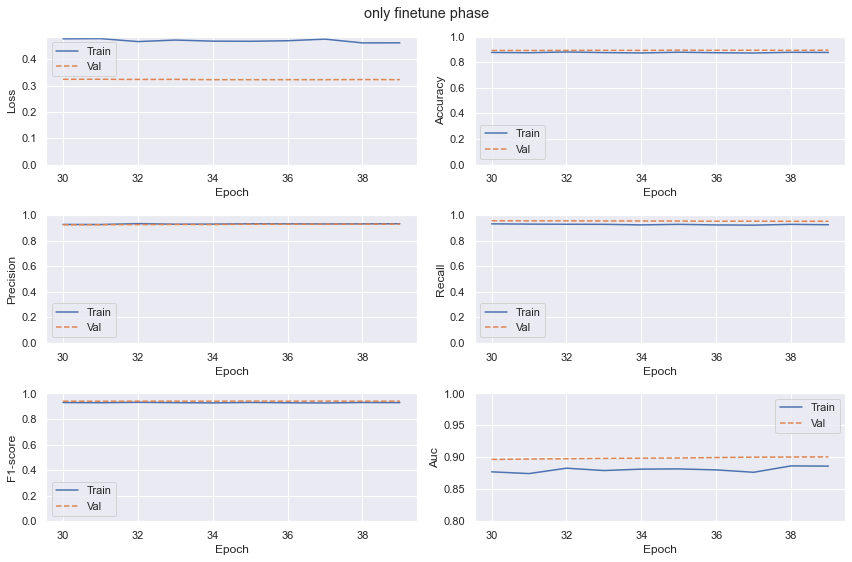

In [76]:
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'f1-score', 'auc',]
# metrics_names = MobileNet_tl.metrics_names
plot_metrics(MobileNet_tl_finetune_history, metrics=metrics_names)
plt.suptitle('only finetune phase')
plt.tight_layout()
plt.show()

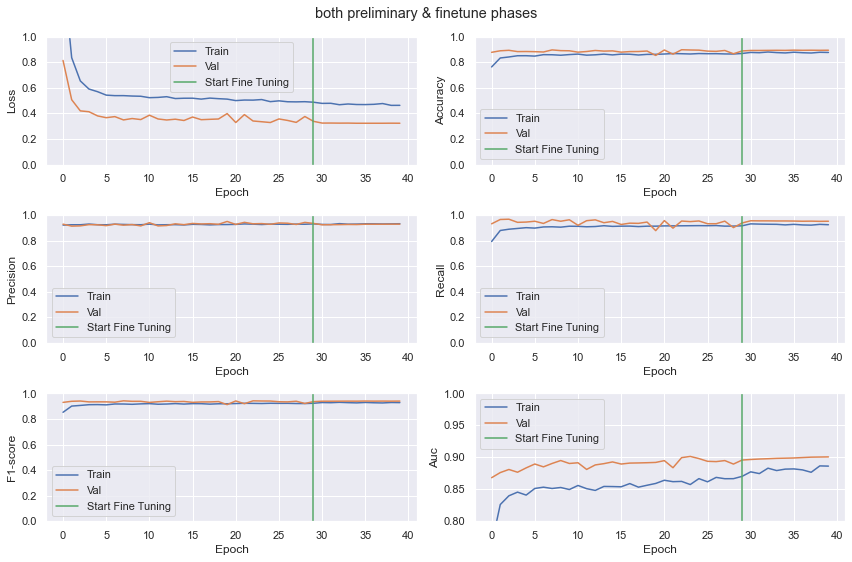

In [77]:
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'f1-score', 'auc',]
# metrics_names = MobileNetv3_tl.metrics_names
plot_metrics_finetune(MobileNet_tl_history,
                      MobileNet_tl_finetune_history,
                      initial_epochs_real,
                      metrics=metrics_names)
plt.suptitle('both preliminary & finetune phases')
plt.tight_layout()
plt.show()

In [78]:
df_metrics = history_df(MobileNet_tl_finetune_history)
display(df_metrics)
# df_metrics.iloc[-1]

loss  accuracy  precision    recall      f1-score       auc      tp  \
0  0.477803  0.876006   0.926045  0.930489   [0.9282619]  0.877334  7175.0   
1  0.478539  0.873915   0.925392  0.928594  [0.92699003]  0.874589  5904.0   
2  0.467306  0.879474   0.932332  0.927493  [0.92990625]  0.883037  5897.0   
3  0.473088  0.874864   0.927885  0.926864  [0.92737424]  0.879336  5893.0   
4  0.468987  0.872153   0.928741  0.922460   [0.9255898]  0.881572  5865.0   
5  0.468446  0.877711   0.931100  0.926706    [0.928898]  0.881901  5892.0   
6  0.470516  0.873780   0.930783  0.922145  [0.92644393]  0.880370  5863.0   
7  0.476544  0.871611   0.929786  0.920573   [0.9251561]  0.876628  5853.0   
8  0.462279  0.877169   0.930648  0.926549  [0.92859393]  0.886603  5891.0   
9  0.462520  0.875813   0.931631  0.923718   [0.9276576]  0.886265  5873.0   

      fp     tn     fn  val_loss  val_accuracy  val_precision  val_recall  \
0  573.0  660.0  536.0  0.323864      0.891400       0.923345    0.954611   
1  476.0  542.0  454.0  0.324092      0.891400       0.923936    0.953891   
2  428.0  590.0  461.0  0.323412      0.892028       0.924581    0.953891   
3  458.0  560.0  465.0  0.323733      0.892655       0.925822    0.953170   
4  450.0  568.0  493.0  0.322513      0.892028       0.925175    0.953170   
5  436.0  582.0  466.0  0.322468      0.893911       0.927719    0.952450   
6  436.0  582.0  495.0  0.322544      0.892655       0.927618    0.951009   
7  442.0  576.0  505.0  0.322526      0.893283       0.927669    0.951729   
8  439.0  579.0  467.0  0.323039      0.892655       0.928220    0.950288   
9  431.0  587.0  485.0  0.322669      0.893283       0.928270    0.951009   

   val_f1-score   val_auc  val_tp  val_fp  val_tn  val_fn  
0  [0.93871766]  0.896652  1325.0   110.0    95.0    63.0  
1   [0.9386742]  0.897354  1324.0   109.0    96.0    64.0  
2  [0.93900704]  0.897821  1324.0   108.0    97.0    64.0  
3   [0.9392971]  0.898385  1323.0   106.0    99.0    65.0  
4   [0.9389638]  0.898677  1323.0   107.0    98.0    65.0  
5  [0.93992174]  0.898993  1322.0   103.0   102.0    66.0  
6  [0.93916756]  0.899652  1320.0   103.0   102.0    68.0  
7   [0.9395448]  0.900293  1321.0   103.0   102.0    67.0  
8   [0.9391242]  0.900494  1319.0   102.0   103.0    69.0  
9  [0.93950176]  0.900685  1320.0   102.0   103.0    68.0

##### Evaluate the Model (MobileNet)

In [79]:
model = MobileNet_tl

a = pd.Series(evaluate_model(model, train_ds), name='Train')
b = pd.Series(evaluate_model(model, val_ds), name='Val')
c = pd.Series(evaluate_model(model, test_ds), name='Test')

df = pd.concat([a, b, c], axis=1)
print('Model evaluation on diff sets')
display(df)

Model evaluation on diff sets


Train           Val          Test
loss          0.316922      0.322669      0.329078
accuracy      0.896556      0.893283      0.891582
precision     0.934192       0.92827      0.927076
recall        0.946681      0.951009      0.949002
f1-score   [0.9403953]  [0.93950176]  [0.93791085]
auc           0.914527      0.900685       0.89132
tp              6019.0        1320.0        1284.0
fp               424.0         102.0         101.0
tn               594.0         103.0         114.0
fn               339.0          68.0          69.0

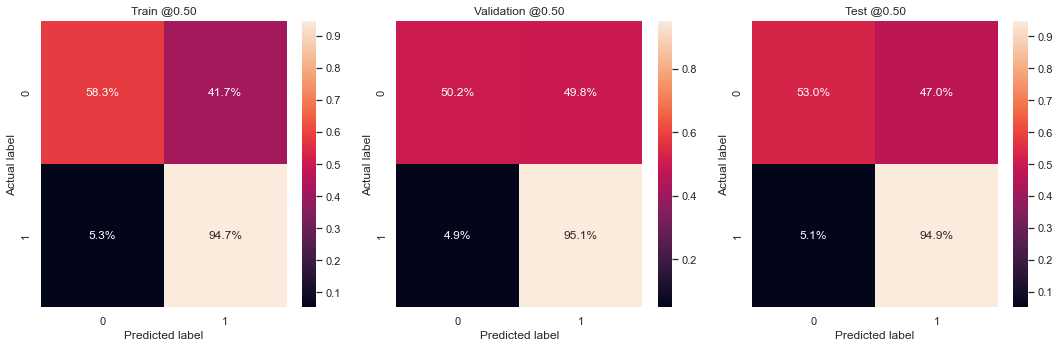

In [80]:
model = MobileNet_tl
datasets = [train_ds, val_ds, test_ds]
datasets_names = iter(['Train', 'Validation', 'Test'])  # should not touch the test set before 1-2 weeks before thesis

# plot the confustion matrices resulted from predicting datasets
plt.figure(figsize=(15,5))
for i in range(len(datasets)):
  dataset_name = next(datasets_names)
  y_true, y_pred = test_model_inference(model, datasets[i], output_neurons=1)
  plt.subplot(1, len(datasets), i+1)
  plot_cm(y_true, y_pred, title=dataset_name)
  # plt.plot([1, 2, 3], [4, 5, 6])

plt.tight_layout()
plt.show()

##### Grad-CAM visualization (Francis Collet method)
<a href="https://www.amazon.com/Learning-Python-Second-Fran%C3%A7ois-Chollet/dp/1617296864/ref=sr_1_3_sspa?crid=N51B6KCESGGT&keywords=amazon+manning+deep+learning&qid=1661541856&s=digital-text&sprefix=amazon+manning+deep+learn%2Cdigital-text%2C531&sr=1-3-spons&psc=1">the book</a>

In [30]:
model = MobileNet_tl
# model = tf.keras.applications.xception.Xception(weights="imagenet")

# define the resize_shape
shape = model.input_shape
resize_shape = (shape[1], shape[2])
print('resize_shape:', resize_shape)

NameError: name 'MobileNet_tl' is not defined

In [31]:
model.summary()

NameError: name 'model' is not defined

In [32]:
pretrained_model = MobileNetV2_pretrained
pretrained_model.summary()

NameError: name 'MobileNetV2_pretrained' is not defined

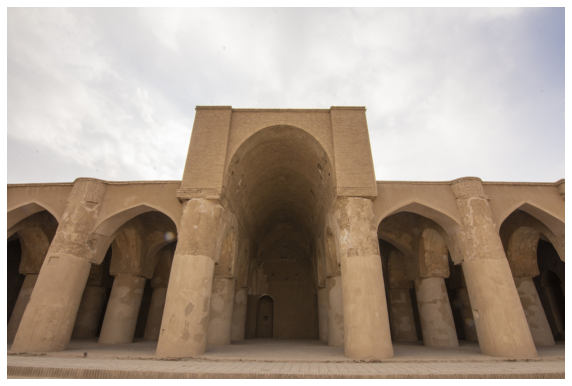

In [35]:
img_path = tf.keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

# define image address
image_names = ['IMG_7968.JPG', 'DSC_0545.JPG', 'DSC02360.JPG']
# for linux
# img_path = str(pathlib.Path(r'/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/DSC_0545.JPG'))
# for windows
img_path = str(pathlib.Path(r'F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\\') / f'{image_names[1]}')

def get_img_array(img_path, target_size):
    # Return a Python Imaging Library (PIL) image of size 299 × 299.
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    # Return a float32 NumPy array of shape (299, 299, 3).
    array = tf.keras.utils.img_to_array(img)
    # Add a dimension to transform the array into a batch of size (1, 299, 299, 3).
    array = np.expand_dims(array, axis=0)
    # Preprocess the batch (this does channel-wise color normalization).
    array = preprocess_input(array)  # make this a parameter (just like that of tl_model_builder)
    return array

img_array = get_img_array(img_path, target_size=input_shape)


plt.figure(figsize=(10, 7))
# convert [1, 1] --> [0, 255]
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.show()

###### step 1: First, we create a model that maps the input image to the activations of the last convolutional layer

In [54]:
# Setting up a model that returns the last convolutional output (feature extraction)
pretrained_model_inside = model.get_layer('pretrained_model')
last_conv_layer_name = 'Conv_1'
# last_conv_layer = pretrained_model_inside.get_layer(last_conv_layer_name)
last_conv_layer = pretrained_model_inside.layers[-1]

# last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
last_conv_layer_model = tf.keras.Model(pretrained_model_inside.inputs, last_conv_layer.output)

###### setp 2: Second, we create a model that maps the activations of the last convolutional layer to the final class predictions.

In [55]:
# Reapplying the classifier on top of the last convolutional output
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input

# # method 1: using layers' names (not so good as need to annotate all layers after the pretrained_model place)
# # classifier_layer_names = ['output_layer']
# classifier_layer_names = ['global_avg_pool', 'FC1', 'output_layer']
# for layer_name in classifier_layer_names:
#     x = model.get_layer(layer_name)(x)

# method 2: using layers' indices (jus need to give the range of indices of layers after the pretrained_model place)
classifier_layer_indices = range(-6, 0)
for layer_index in classifier_layer_indices:
    x = model.layers[layer_index](x)

classifier_model = tf.keras.Model(classifier_input, x)

###### step 3: Then we compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer.

In [56]:
# Retrieving the gradients of the top predicted class
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it.
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Retrieve the activation channel corresponding to the top predicted class.
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to the output feature map of the last convolutional layer.
grads = tape.gradient(top_class_channel, last_conv_layer_output)

###### step 4: Now we apply pooling and importance weighting to the gradient tensor to obtain our heatmap of class activation.

In [57]:
# Gradient pooling and channel-importance weighting

# This is a vector where each entry is the mean intensity of the gradient for a given channel. It quantifies the importance of each channel with regard to the top predicted class.
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]

# Multiply each channel in the output of the last convolutional layer by “how important this channel is."
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map is our heatmap of class activation.
heatmap = np.mean(last_conv_layer_output, axis=-1)

###### step 5: For visualization purposes, we’ll also normalize the heatmap between 0 and 1. The result is shown in figure 9.19.

<Figure size 720x504 with 0 Axes>

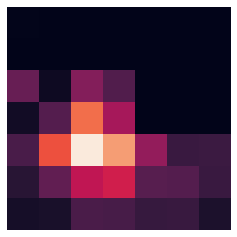

In [58]:
# Heatmap post-processing: to plot a Standalone class activation heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.figure(figsize=(10, 7))
plt.matshow(heatmap)
plt.axis('off')
plt.show()

###### step 6: Finally, let’s generate an image that superimposes the original image on the heatmap we just obtained (see figure 9.20).

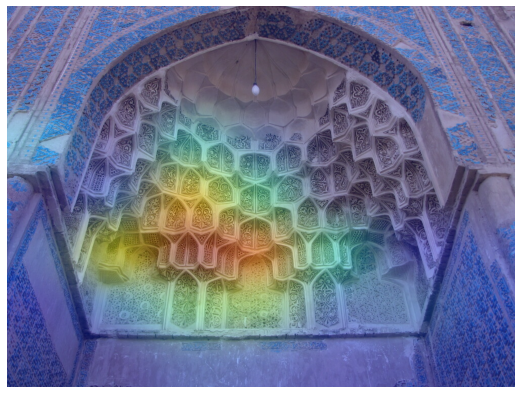

In [61]:
import matplotlib.cm as cm

# Load the original image
img = tf.keras.utils.load_img(img_path)
img = tf.keras.utils.img_to_array(img)

# Rescale the heatmap to the range 0–255
heatmap = np.uint8(255 * heatmap)

# Use the "jet" colormap to recolorize the heatmap.
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image that contains the recolorized heatmap
jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

# Superimpose the heatmap and the original image, with the heatmap at 40% opacity
superimposed_img = jet_heatmap * 0.5 + img
superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

# Save the superimposed image.
save_path = "Grad_CAM outputs/" + img_path.split(os.sep)[-1]
superimposed_img.save(save_path)

plt.figure(figsize=(10, 7))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

##### Grad-CAM visualization (pyimagesearch's method)
<a href="https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/">the article</a>

In [ ]:
# # put this cell to a file --> "./ancillary files/gradcam.py"
# # import the necessary packages
# from tensorflow.keras.models import Model
# import tensorflow as tf
# import numpy as np
# import cv2

# class GradCAM:
# 	def __init__(self, model, classIdx, layerName=None):
# 		# store the model, the class index used to measure the class
# 		# activation map, and the layer to be used when visualizing
# 		# the class activation map
# 		self.model = model
# 		self.classIdx = classIdx
# 		self.layerName = layerName
# 		# if the layer name is None, attempt to automatically find
# 		# the target output layer
# 		if self.layerName is None:
# 			self.layerName = self.find_target_layer()

# 	def find_target_layer(self):
# 		# attempt to find the final convolutional layer in the network
# 		# by looping over the layers of the network in reverse order
# 		for layer in reversed(self.model.layers):
# 			# check to see if the layer has a 4D output
# 			if len(layer.output_shape) == 4:
# 				return layer.name
# 		# otherwise, we could not find a 4D layer so the GradCAM
# 		# algorithm cannot be applied
# 		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

# 	def compute_heatmap(self, image, eps=1e-8):
# 		# construct our gradient model by supplying (1) the inputs
# 		# to our pre-trained model, (2) the output of the (presumably)
# 		# final 4D layer in the network, and (3) the output of the
# 		# softmax activations from the model
# 		gradModel = Model(
# 			inputs=[self.model.inputs],
# 			outputs=[self.model.get_layer(self.layerName).output,
# 				self.model.output])

#         # record operations for automatic differentiation
# 		with tf.GradientTape() as tape:
# 			# cast the image tensor to a float-32 data type, pass the
# 			# image through the gradient model, and grab the loss
# 			# associated with the specific class index
# 			inputs = tf.cast(image, tf.float32)
# 			(convOutputs, predictions) = gradModel(inputs)
# 			# loss = predictions[:, self.classIdx]
# 			loss = predictions
# 		# use automatic differentiation to compute the gradients
# 		grads = tape.gradient(loss, convOutputs)

#         # compute the guided gradients
# 		castConvOutputs = tf.cast(convOutputs > 0, "float32")
# 		castGrads = tf.cast(grads > 0, "float32")
# 		guidedGrads = castConvOutputs * castGrads * grads
# 		# the convolution and guided gradients have a batch dimension
# 		# (which we don't need) so let's grab the volume itself and
# 		# discard the batch
# 		convOutputs = convOutputs[0]
# 		guidedGrads = guidedGrads[0]

# 		# compute the average of the gradient values, and using them
# 		# as weights, compute the ponderation of the filters with
# 		# respect to the weights
# 		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
# 		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

#         # grab the spatial dimensions of the input image and resize
# 		# the output class activation map to match the input image
# 		# dimensions
# 		(w, h) = (image.shape[2], image.shape[1])
# 		heatmap = cv2.resize(cam.numpy(), (w, h))
# 		# normalize the heatmap such that all values lie in the range
# 		# [0, 1], scale the resulting values to the range [0, 255],
# 		# and then convert to an unsigned 8-bit integer
# 		numer = heatmap - np.min(heatmap)
# 		denom = (heatmap.max() - heatmap.min()) + eps
# 		heatmap = numer / denom
# 		heatmap = (heatmap * 255).astype("uint8")
# 		# return the resulting heatmap to the calling function
# 		return heatmap

# 	def overlay_heatmap(self, heatmap, image, alpha=0.5,
# 		colormap=cv2.COLORMAP_VIRIDIS):
# 		# apply the supplied color map to the heatmap and then
# 		# overlay the heatmap on the input image
# 		heatmap = cv2.applyColorMap(heatmap, colormap)
# 		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
# 		# return a 2-tuple of the color mapped heatmap and the output,
# 		# overlaid image
# 		return (heatmap, output)

In [ ]:
# put this cell to a file --> "./ancillary files/apply_gradcam.py"
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import argparse
import imutils
import cv2

def apply_gradcam(img_path, model, output_neurons:int=1):
    '''
    
    args:
        img_path: path to the input image
        model: a CNN model to be used
        output_neurons: the # neurons in the output layer
            e.g., 1 for binary classification, 3 for multi-class classification (with 3 labels)

    return:

    '''
    # load the original image from disk (in OpenCV format) and then
    # resize the image to its target dimensions
    orig = cv2.imread(img_path)
    resized = cv2.resize(orig, (224, 224))
    # load the input image from disk (in Keras/TensorFlow format) and
    # preprocess it
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)

    # use the network to make predictions on the input image and find
    # the class label index with the largest corresponding probability
    if output_neurons == 1:
        preds = model.predict(image).squeeze()
        if preds < 0.5:
            i = 0
            label = train_ds_orig.class_names[0]
        else:
            i = 1
            label = train_ds_orig.class_names[1]
    elif output_neurons > 1:
        preds = model.predict(image)
        print('preds:', preds)
        i = np.argmax(preds[0])
        # decode the ImageNet predictions to obtain the human-readable label
        decoded = imagenet_utils.decode_predictions(preds)
        (imagenetID, label, prob) = decoded[0][0]
        label = "{}: {:.2f}%".format(label, prob * 100)
        print("[INFO] {}".format(label))
    else:
        raise Exception('output_neurons arg must be an int >= 1')

    # initialize our gradient class activation map and build the heatmap
    cam = GradCAM(model, classIdx=i, layerName='output_layer')
    heatmap = cam.compute_heatmap(image)
    # resize the resulting heatmap to the original input image dimensions
    # and then overlay heatmap on top of the image
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

    # draw the predicted label on the output image
    cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
    cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
        0.8, (255, 255, 255), 2)
    # display the original image and resulting heatmap and output image
    # to our screen
    output = np.vstack([orig, heatmap, output])
    output = imutils.resize(output, height=700)
    cv2.imshow("Output", output)
    cv2.waitKey(0)


apply_gradcam(img_path=img_path, model=MobileNet_tl, output_neurons=1)

1/1 [==============================] - 0s 19ms/step


2022-08-27 00:31:18.612191: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at reduction_ops_common.h:147 : INVALID_ARGUMENT: Invalid reduction dimension (1 for input with 1 dimension(s)


InvalidArgumentError: Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Mean]

['NO restoration', 'YES restoration']

##### predict with the MobileNetv3_tl

img_final shape: (1, 224, 224, 3)
the inference:
[[0.03]]
confidence:
 0.97


<function matplotlib.pyplot.show(close=None, block=None)>

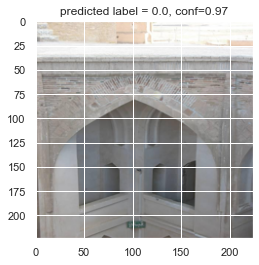

In [ ]:
model = MobileNet_tl

# define the resize_shape
shape = model.input_shape
resize_shape = (shape[1], shape[2])

# define image address
# addr = r'/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/75.JPG'
# addr = r"F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"
addr = r"F:\Thesis Data\Pix\0 Model Ready Data\1. Image Classification\NO restoration\ME\IMG_4579.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = model.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")

if inference.squeeze() < .5:
    confidence = (1. - inference.squeeze()).round(2)
    print('confidence:\n', confidence)
else:
    confidence =  inference.squeeze().round(2)
    print('confidence:\n', confidence)

# for binary classification 
label = (inference.squeeze()).round()  # used .squeeze() since the shape of inference is (1, C)
# for multi-class classification 
# label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)

plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}, conf={confidence}')
plt.show

### Inception

#### 4. Load a pretrained Inception
> we just use a pretrained Inception (trained with ImageNet) to do transfer learning

In [246]:
# InceptionResNetV3_pretrained = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
InceptionResNetV2_pretrained = tf.keras.applications.InceptionResNetV2(input_shape=input_shape,
                                                                       include_top=False,
                                                                       weights='imagenet')

Inception_pretrained = InceptionResNetV2_pretrained

# load the preprocessing of the base/pretrained model
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input


219055592/219055592 [==============================] - 119s 1us/step


In [247]:
# instantiate a Transfer Learning Model
Inception_tl = tl_model_builder(Inception_pretrained,
                                input_shape=input_shape,
                                preprocess_layer=preprocess_input,
                                drop_prob=0.6,
                                lambda_=0.01,
                                value_range=(-1.0, 1.0))

In [248]:
# compile the model

# set LR_decay method
base_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

Inception_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                     loss=tf.keras.losses.BinaryCrossentropy(
                         from_logits=False),
                     metrics=metrics)

In [249]:
# check the performance of pretrained model (before training the added layers)
loss0, accuracy0, *_ = Inception_tl.evaluate(val_ds, verbose=0)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.82
initial accuracy: 0.34


##### Train the added layers 
> to the pretrained ResNet50v2

In [250]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # monitor='val_prc',
    # monitor='val_auc',
    verbose=0,
    patience=5,
    # patience=10,
    mode='auto',
    restore_best_weights=True)

In [251]:
initial_epochs = 30

Inception_tl_history = Inception_tl.fit(train_ds,
                                        validation_data=val_ds,
                                        epochs=initial_epochs,
                                        # callbacks=[early_stopping],  # dont use early_stopping as we lose orthoginalization
                                        # class_weight=None)
                                        class_weight=class_weight)


Epoch 1/30
231/231 [==============================] - 59s 218ms/step - loss: 1.6546 - accuracy: 0.7240 - precision: 0.9132 - recall: 0.7512 - f1_score: 0.8243 - auc: 0.7146 - tp: 4776.0000 - fp: 454.0000 - tn: 564.0000 - fn: 1582.0000 - val_loss: 0.8523 - val_accuracy: 0.8738 - val_precision: 0.9093 - val_recall: 0.9494 - val_f1_score: 0.9289 - val_auc: 0.8423 - val_tp: 1313.0000 - val_fp: 131.0000 - val_tn: 79.0000 - val_fn: 70.0000
Epoch 2/30
231/231 [==============================] - 50s 217ms/step - loss: 0.9202 - accuracy: 0.8147 - precision: 0.9105 - recall: 0.8706 - f1_score: 0.8901 - auc: 0.7772 - tp: 5535.0000 - fp: 544.0000 - tn: 474.0000 - fn: 823.0000 - val_loss: 0.5542 - val_accuracy: 0.8795 - val_precision: 0.8926 - val_recall: 0.9790 - val_f1_score: 0.9338 - val_auc: 0.8502 - val_tp: 1354.0000 - val_fp: 163.0000 - val_tn: 47.0000 - val_fn: 29.0000
Epoch 3/30
231/231 [==============================] - 50s 219ms/step - loss: 0.7113 - accuracy: 0.8250 - precision: 0.9076 - 

##### Plot the training performance

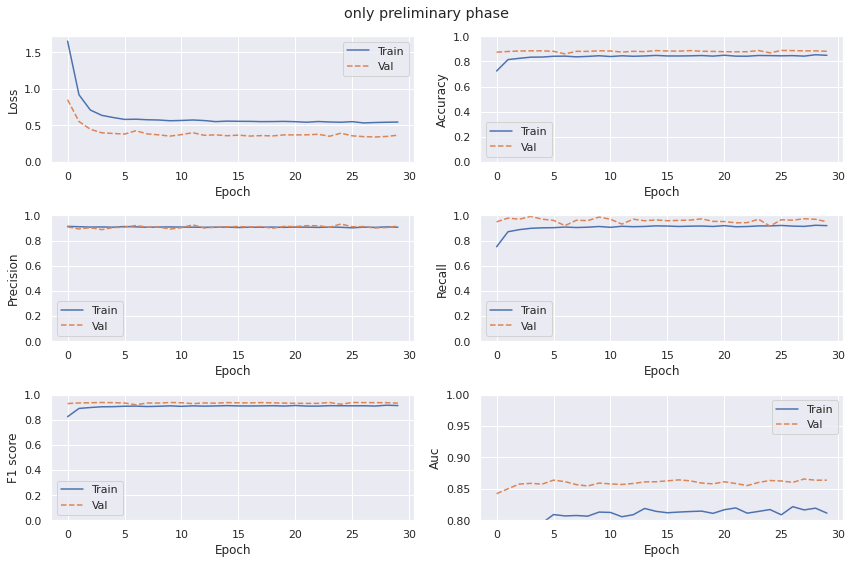

In [255]:
# if using class_weight then loss of train set is not comparable (with that of val set)
# metrics_names = Inception_tl.metrics_names
plot_metrics(Inception_tl_history, metrics=metrics_names)
plt.suptitle('only preliminary phase')
plt.tight_layout()
plt.show()

In [258]:
df_metrics = history_df(Inception_tl_history)

# method 1: ugly print
display(df_metrics)

# method 2: clean print
# merge the metrics for both train & val (e.g., merge loss and val_loss)
for feat in df_metrics.columns:
    df_metrics.rename(columns={feat: feat.replace('val_', '')}, inplace=True)

train_set_margin = int(len(df_metrics.columns)/2)
sets_metrics_separate = {'train': df_metrics.iloc[-1][:train_set_margin],
                         'val': df_metrics.iloc[-1][train_set_margin:]}

print('last epoch\'s metrics (of diff sets)')
display(pd.DataFrame(sets_metrics_separate))

loss  accuracy  precision    recall      f1_score       auc      tp  \
0   1.654578  0.723970   0.913193  0.751180  [0.82430106]  0.714595  4776.0   
1   0.920180  0.814669   0.910512  0.870557   [0.8900861]  0.777157  5535.0   
2   0.711284  0.824973   0.907643  0.887229   [0.8973196]  0.794675  5641.0   
3   0.638579  0.834192   0.908772  0.897767  [0.90323603]  0.799098  5708.0   
4   0.608965  0.835141   0.906546  0.901699  [0.90411603]  0.795776  5733.0   
..       ...       ...        ...       ...           ...       ...     ...   
25  0.552278  0.844902   0.901695  0.920415   [0.9109589]  0.808751  5852.0   
26  0.534772  0.846394   0.907249  0.915382  [0.91129726]  0.821691  5820.0   
27  0.540452  0.842462   0.905051  0.913023   [0.9090197]  0.816522  5805.0   
28  0.544302  0.853308   0.909119  0.921988   [0.9155084]  0.819311  5862.0   
29  0.546834  0.848834   0.906749  0.919157  [0.91291106]  0.811421  5844.0   

       fp     tn      fn  val_loss  val_accuracy  val_precision  val_recall  \
0   454.0  564.0  1582.0  0.852332      0.873823       0.909280    0.949385   
1   544.0  474.0   823.0  0.554170      0.879473       0.892551    0.979031   
2   574.0  444.0   717.0  0.448637      0.883239       0.902488    0.970354   
3   573.0  445.0   650.0  0.399346      0.884495       0.887524    0.992769   
4   591.0  427.0   625.0  0.390606      0.884495       0.903704    0.970354   
..    ...    ...     ...       ...           ...            ...         ...   
25  638.0  380.0   506.0  0.358303      0.887633       0.910082    0.966016   
26  595.0  423.0   538.0  0.347374      0.886378       0.911644    0.962401   
27  609.0  409.0   553.0  0.342624      0.884495       0.901003    0.973970   
28  586.0  432.0   496.0  0.349812      0.884495       0.904248    0.969631   
29  601.0  417.0   514.0  0.367009      0.880728       0.915679    0.950108   

    val_f1_score   val_auc  val_tp  val_fp  val_tn  val_fn  
0    [0.9288999]  0.842287  1313.0   131.0    79.0    70.0  
1    [0.9337931]  0.850248  1354.0   163.0    47.0    29.0  
2    [0.9351917]  0.857713  1342.0   145.0    65.0    41.0  
3    [0.9372013]  0.858784  1373.0   174.0    36.0    10.0  
4   [0.93584377]  0.857608  1342.0   143.0    67.0    41.0  
..           ...       ...     ...     ...     ...     ...  
25  [0.93721503]  0.862586  1336.0   132.0    78.0    47.0  
26  [0.93633485]  0.860335  1331.0   129.0    81.0    52.0  
27  [0.93606675]  0.865728  1347.0   148.0    62.0    36.0  
28    [0.935799]  0.863807  1341.0   142.0    68.0    42.0  
29   [0.9325763]  0.863850  1314.0   121.0    89.0    69.0  

[30 rows x 20 columns]

last epoch's metrics (of diff sets)


train          val
loss           0.546834     0.367009
accuracy       0.848834     0.880728
precision      0.906749     0.915679
recall         0.919157     0.950108
f1_score   [0.91291106]  [0.9325763]
auc            0.811421      0.86385
tp               5844.0       1314.0
fp                601.0        121.0
tn                417.0         89.0
fn                514.0         69.0

In [259]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(Inception_pretrained.layers))

Number of layers in the base model:  780


##### Fine-tune the top layers (of the base/pretrained model)

In [260]:
#  unfreeze the base_model
Inception_pretrained.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 700  # for InceptionResNetV2

# set the bottom layers to be un-trainable.
# Freeze all the layers before the `fine_tune_at` layer
for layer in Inception_pretrained.layers[:fine_tune_at]:
    layer.trainable = False

# recompile the model (necessary for these changes to take effect)
# As you are training a much larger model and want to readapt the pretrained weights,
# it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

# set LR_decay method (for fine-tuning)
fine_tune_lr = 1e-8
# fine_tune_lr = base_learning_rate/100
lr_schedule_finetune = tf.keras.optimizers.schedules.ExponentialDecay(
    fine_tune_lr,
    decay_steps=300,
    decay_rate=0.96,
    staircase=True)

Inception_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_finetune),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=metrics)


In [262]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',
    # monitor='val_prc',
    monitor='val_auc',
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [263]:
# resume training
fine_tune_epochs = 10
# might differ from initial_epochs if used early stopping
initial_epochs_real = len(Inception_tl_history.history['loss'])
total_epochs = initial_epochs_real + fine_tune_epochs

Inception_tl_finetune_history = Inception_tl.fit(train_ds,
                                                 validation_data=val_ds,
                                                 epochs=total_epochs,
                                                 initial_epoch=initial_epochs_real,
                                                 # dont use early_stopping as we lose orthoginalization
                                                 callbacks=[early_stopping],
                                                 # class_weight=None)
                                                 class_weight=class_weight)


Epoch 31/40
231/231 [==============================] - 71s 270ms/step - loss: 0.5322 - accuracy: 0.8643 - precision: 0.9041 - recall: 0.9426 - f1_score: 0.9229 - auc: 0.8287 - tp: 5993.0000 - fp: 636.0000 - tn: 382.0000 - fn: 365.0000 - val_loss: 0.3641 - val_accuracy: 0.8826 - val_precision: 0.9141 - val_recall: 0.9544 - val_f1_score: 0.9339 - val_auc: 0.8635 - val_tp: 1320.0000 - val_fp: 124.0000 - val_tn: 86.0000 - val_fn: 63.0000
Epoch 32/40
231/231 [==============================] - 59s 256ms/step - loss: 0.5299 - accuracy: 0.8656 - precision: 0.9063 - recall: 0.9415 - f1_score: 0.9236 - auc: 0.8319 - tp: 5986.0000 - fp: 619.0000 - tn: 399.0000 - fn: 372.0000 - val_loss: 0.3636 - val_accuracy: 0.8814 - val_precision: 0.9129 - val_recall: 0.9544 - val_f1_score: 0.9332 - val_auc: 0.8636 - val_tp: 1320.0000 - val_fp: 126.0000 - val_tn: 84.0000 - val_fn: 63.0000
Epoch 33/40
231/231 [==============================] - 59s 254ms/step - loss: 0.5308 - accuracy: 0.8563 - precision: 0.9017 

##### Plot the training performance

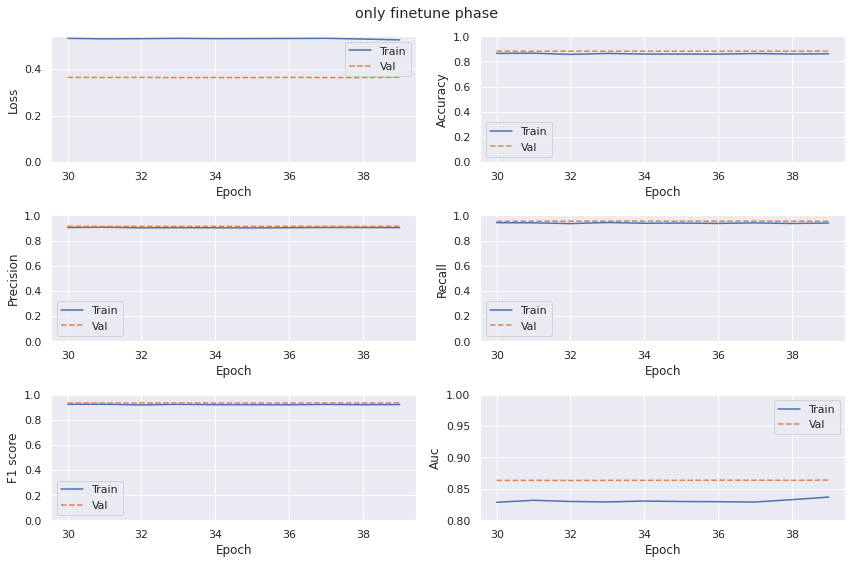

In [264]:
# metrics_names = Inception_tl.metrics_names
plot_metrics(Inception_tl_finetune_history, metrics=metrics_names)
plt.suptitle('only finetune phase')
plt.tight_layout()
plt.show()

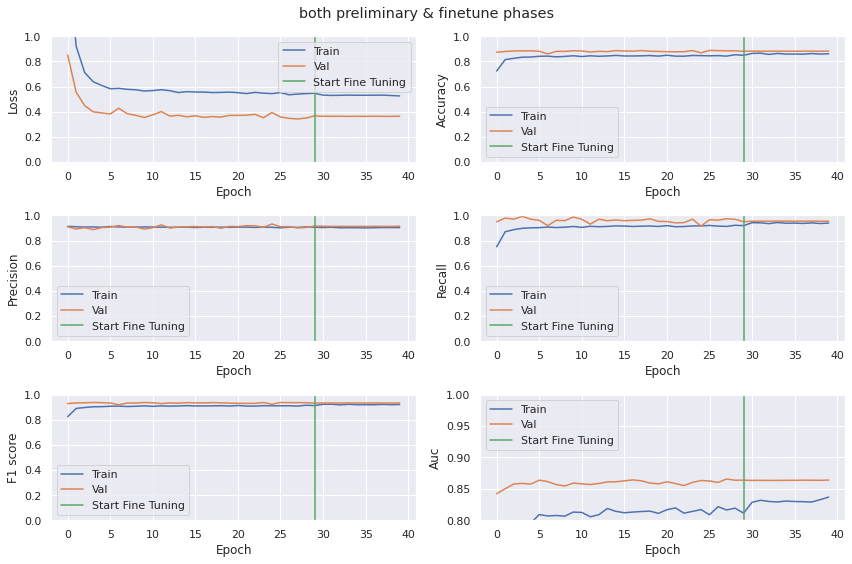

In [265]:
# metrics_names = Inception_tl.metrics_names
plot_metrics_finetune(Inception_tl_history,
                      Inception_tl_finetune_history,
                      initial_epochs_real,
                      metrics=metrics_names)

plt.suptitle('both preliminary & finetune phases')
plt.tight_layout()
plt.show()

In [ ]:
df_metrics = history_df(Inception_tl_finetune_history)
display(df_metrics)
# df_metrics.iloc[-1]

loss  accuracy  precision    recall       auc       prc      tp     fp  \
0  0.366793  0.820939   0.876279  0.900535  0.855577  0.956889  4880.0  689.0   
1  0.318842  0.859542   0.887888  0.940511  0.907739  0.973393  4237.0  535.0   
2  0.279491  0.878433   0.905492  0.944284  0.933385  0.981339  4254.0  444.0   
3  0.238765  0.902221   0.925582  0.952497  0.953795  0.987430  4291.0  345.0   
4  0.199056  0.918489   0.941614  0.955827  0.969504  0.991900  4306.0  267.0   
5  0.165773  0.930208   0.953802  0.957825  0.979623  0.994681  4315.0  209.0   
6  0.137225  0.943677   0.964881  0.963596  0.986673  0.996527  4341.0  158.0   

       tn     fn  val_loss  val_accuracy  val_precision  val_recall   val_auc  \
0   750.0  539.0  0.381076      0.849255       0.871000    0.952954  0.846427   
1   677.0  268.0  0.374410      0.848379       0.873112    0.948578  0.856286   
2   768.0  251.0  0.390767      0.841367       0.870576    0.942013  0.860445   
3   867.0  214.0  0.412871      0.836985       0.873717    0.931072  0.858867   
4   945.0  199.0  0.479307      0.836985       0.883966    0.916849  0.850522   
5  1003.0  190.0  0.548354      0.839614       0.881923    0.923414  0.841477   
6  1054.0  164.0  0.615048      0.829097       0.878023    0.913567  0.836460   

    val_prc  val_tp  val_fp  val_tn  val_fn  
0  0.951746   871.0   129.0    98.0    43.0  
1  0.953634   867.0   126.0   101.0    47.0  
2  0.954904   861.0   128.0    99.0    53.0  
3  0.952877   851.0   123.0   104.0    63.0  
4  0.945829   838.0   110.0   117.0    76.0  
5  0.940052   844.0   113.0   114.0    70.0  
6  0.937147   835.0   116.0   111.0    79.0

##### Evaluate the Model (Inception)

In [266]:
model = Inception_tl

a = pd.Series(evaluate_model(model, train_ds), name='Train')
b = pd.Series(evaluate_model(model, val_ds), name='Val')
c = pd.Series(evaluate_model(model, test_ds), name='Test')

df = pd.concat([a, b, c], axis=1)
display(df)

Train          Val          Test
loss           0.363932     0.364527      0.372166
accuracy       0.878118     0.882611      0.876276
precision      0.907084     0.914702      0.905594
recall          0.95659     0.953724      0.956425
f1_score   [0.93117964]  [0.9338053]  [0.93031615]
auc              0.8695     0.864031      0.849446
tp               6082.0       1319.0        1295.0
fp                623.0        123.0         135.0
tn                395.0         87.0          79.0
fn                276.0         64.0          59.0

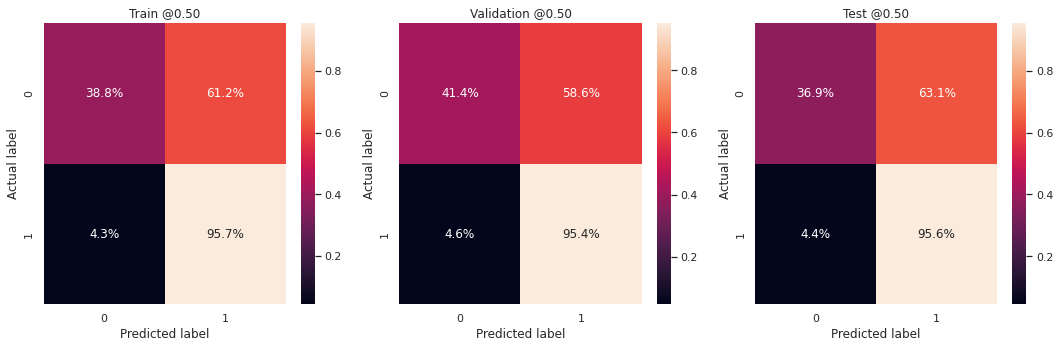

In [267]:
model = Inception_tl
datasets = [train_ds, val_ds, test_ds]
datasets_names = iter(['Train', 'Validation', 'Test'])  # should not touch the test set before 1-2 weeks before thesis

# plot the confustion matrices resulted from predicting datasets
plt.figure(figsize=(15,5))
for i in range(len(datasets)):
  dataset_name = next(datasets_names)
  y_true, y_pred = test_model_inference(model, datasets[i], output_neurons=1)
  plt.subplot(1, len(datasets), i+1)
  plot_cm(y_true, y_pred, title=dataset_name)
  # plt.plot([1, 2, 3], [4, 5, 6])

plt.tight_layout()
plt.show()

##### predict with the Inception_tl

img_final shape: (1, 160, 160, 3)
the inference:
[[0.36]]
confidence:
 0.64


<function matplotlib.pyplot.show(close=None, block=None)>

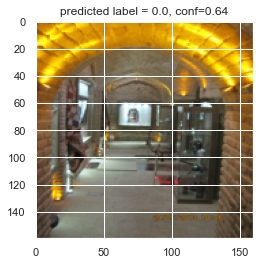

In [ ]:
model = Inception_tl

# define the resize_shape
shape = model.input_shape
resize_shape = (shape[1], shape[2])

# define image address
# addr = r'/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/75.JPG'
# addr = r"F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"
addr = r"F:\Thesis Data\Pix\0 Model Ready Data\1. Image Classification\NO restoration\ME\IMG_4579.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = model.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")

if inference.squeeze() < .5:
    confidence = (1. - inference.squeeze()).round(2)
    print('confidence:\n', confidence)
else:
    confidence =  inference.squeeze().round(2)
    print('confidence:\n', confidence)

# for binary classification 
label = (inference.squeeze()).round()  # used .squeeze() since the shape of inference is (1, C)
# for multi-class classification 
# label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)

plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}, conf={confidence}')
plt.show

### Comapre all the models
> in terms of Loss, Accuracy, etc.

In [ ]:
print("ResNet50 (scratch)".center(79, '-'))
print("Loss = " + str(ResNet50_scratch_history.history[0]))
print("Test Accuracy = " + str(ResNet50_scratch_history[1]))

print("ResNet50v2 (Transfer Learning)".center(79, '-'))
print("Loss = " + str(ResNet50v2_tl_finetune_history[0]))
print("Test Accuracy = " + str(ResNet50v2_tl_finetune_history[1]))

print("MobileNetv3 (Transfer Learning)".center(79, '-'))
print("Loss = " + str(MobileNetv3_tl_finetune_history[0]))
print("Test Accuracy = " + str(MobileNetv3_tl_finetune_history[1]))


models_history = {'ResNet50_scratch': ResNet50_scratch_history,
                  'ResNet50v2_tl': ResNet50v2_tl_finetune_history,
                  'MobileNetv3_tl': MobileNetv3_tl_finetune_history}

for i in range(2):
    plt.subplot(1, 2, i+1)
    model_history = models_history.items()[i]
    for history in models_history:
        plt.bar(history, models_history[history]['loss'], width=1)
    plt.xlabel('Model')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.show()

# plt.bar('ResNet50 (scratch)', preds_scratch[1], width=1)
# plt.bar('ResNet50 (pre-trained)', preds_pretrained[1], width=1)
# plt.xlabel('Model')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# plt.show()


# # using pandas + seaborn
# df = pd.DataFrame({'set': ['train', 'train', 'val', 'val', 'test', 'test'], 'label': ['NO', 'YES']*3, 'recs': x})
# # display(df)

# g = sns.catplot(
#     data=df,
#     x="set",
#     y="recs",
#     hue="label",
#     kind="bar",
#     height=5,
#     ci="sd",
#     # palette='husl', # set the color palette
#     # alpha=0.6,  # set the opacity
# )

# sns.set(style="darkgrid")
# g.despine(left=True)
# g.set_axis_labels("", "#images\n", fontsize=14)
# # g.legend.set_title("class/label", )
# g._legend.remove()  # to remove sns automatic legend (and use matplot's)
# plt.legend(loc='upper right', title='Class/Label')
# plt.show()


1. although the pretrained ResNet50 has scored slightly lower than the from scratch ResNet50, but:
* the pretrained model was trained with ImageNet but we tested it with sign dataset, so the results are great
* faster (than ResNet50 from scratch) as we didn't spend time training it 
2. if we have the time, computational power and a large dataset to train a model from scratch, then the results would be better (at least slightly)
> but <u>maybe</u> with transfer learning (especially with a small dataset) we can fare better
